In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Julia"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using PDMPFlux

In [3]:
function U_Gauss(x::Vector)
    return sum(x.^2) / 2
end

U_Gauss (generic function with 1 method)

In [4]:
dim = 10
sampler = ZigZagAD(dim, U_Gauss)

ZigZag(10, 0.0, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}(ForwardDiff, Main.U_Gauss), 10, 2.0, true, true, true, PDMPFlux.var"#22#24"(), PDMPFlux.var"#_global_rate#25"{Int64, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}, PDMPFlux.var"#22#24"}(10, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}(ForwardDiff, Main.U_Gauss), PDMPFlux.var"#22#24"()), PDMPFlux.var"#_global_rate_vect#26"{Int64, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}, PDMPFlux.var"#22#24"}(10, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}(ForwardDiff, Main.U_Gauss), PDMPFlux.var"#22#24"()), nothing, PDMPFlux.var"#_signed_rate_vect#27"{PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}, PDMPFlux.var"#22#24"}(PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}(ForwardDiff, Main.U_Gauss), PDMPFlux.var"#22#24"()), PDMPFlux.var"#velocity_jump#28"{Int64, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}}(10, PDMPFlux.var"#32#35"{Module, typeof(U_Gauss)}(ForwardDiff, Main.U_Gauss)), nothing)

In [5]:
#| output: false
N_sk, N, xinit, vinit = 1_000_000, 1_000_000, zeros(dim), ones(dim)
samples = sample(sampler, N_sk, N, xinit, vinit, seed=2024)

0.0%

┣                                      ┫ 0B/1.0MB [00:02<-519:-3:-56, -2s/B]


0.0%┣                                        ┫ 1B/1.0MB [00:02<Inf:Inf, InfGs/B]
0.1%┣                                         ┫ 727B/1.0MB [00:02<51:33, 323B/s]


0.2%┣                                        ┫ 1.6kB/1.0MB [00:02<24:37, 676B/s]
0.2%┣                                       ┫ 2.4kB/1.0MB [00:02<16:21, 1.0kB/s]


0.3%┣▏                                      ┫ 3.2kB/1.0MB [00:02<12:25, 1.3kB/s]
0.4%┣▏                                      ┫ 4.2kB/1.0MB [00:02<09:48, 1.7kB/s]


0.5%┣▏                                      ┫ 5.1kB/1.0MB [00:02<08:11, 2.0kB/s]
0.6%┣▏                                      ┫ 5.7kB/1.0MB [00:03<07:31, 2.2kB/s]


0.6%┣▎                                      ┫ 5.8kB/1.0MB [00:03<07:44, 2.1kB/s]
0.7%┣▎                                      ┫ 6.5kB/1.0MB [00:03<07:01, 2.4kB/s]


0.7%┣▎                                      ┫ 7.3kB/1.0MB [00:03<06:20, 2.6kB/s]
0.8%┣▎                                      ┫ 8.0kB/1.0MB [00:03<05:54, 2.8kB/s]


0.9%┣▍                                      ┫ 8.6kB/1.0MB [00:03<05:36, 3.0kB/s]
0.9%┣▍                                      ┫ 9.3kB/1.0MB [00:03<05:15, 3.1kB/s]


1.0%┣▍                                     ┫ 10.2kB/1.0MB [00:03<04:54, 3.4kB/s]
1.1%┣▍                                     ┫ 11.0kB/1.0MB [00:03<04:35, 3.6kB/s]


1.2%┣▌                                     ┫ 11.9kB/1.0MB [00:03<04:18, 3.8kB/s]
1.3%┣▌                                     ┫ 12.9kB/1.0MB [00:03<04:02, 4.1kB/s]


1.4%┣▌                                     ┫ 13.9kB/1.0MB [00:03<03:48, 4.3kB/s]
1.5%┣▋                                     ┫ 14.9kB/1.0MB [00:03<03:36, 4.6kB/s]


1.6%┣▋                                     ┫ 15.9kB/1.0MB [00:03<03:25, 4.8kB/s]
1.7%┣▋                                     ┫ 16.9kB/1.0MB [00:03<03:16, 5.0kB/s]


1.8%┣▊                                     ┫ 17.9kB/1.0MB [00:03<03:08, 5.2kB/s]
1.9%┣▊                                     ┫ 18.7kB/1.0MB [00:03<03:02, 5.4kB/s]


2.0%┣▊                                     ┫ 19.7kB/1.0MB [00:04<02:55, 5.6kB/s]
2.1%┣▉                                     ┫ 20.6kB/1.0MB [00:04<02:50, 5.8kB/s]


2.2%┣▉                                     ┫ 21.5kB/1.0MB [00:04<02:45, 5.9kB/s]
2.2%┣▉                                     ┫ 22.4kB/1.0MB [00:04<02:40, 6.1kB/s]


2.3%┣▉                                     ┫ 23.2kB/1.0MB [00:04<02:37, 6.2kB/s]
2.4%┣█                                     ┫ 24.1kB/1.0MB [00:04<02:33, 6.4kB/s]


2.5%┣█                                     ┫ 24.9kB/1.0MB [00:04<02:30, 6.5kB/s]
2.6%┣█                                     ┫ 25.7kB/1.0MB [00:04<02:27, 6.6kB/s]


2.7%┣█                                     ┫ 26.6kB/1.0MB [00:04<02:24, 6.8kB/s]
2.7%┣█                                     ┫ 27.4kB/1.0MB [00:04<02:21, 6.9kB/s]


2.8%┣█                                     ┫ 28.4kB/1.0MB [00:04<02:18, 7.0kB/s]
2.9%┣█▏                                    ┫ 29.3kB/1.0MB [00:04<02:15, 7.2kB/s]


3.0%┣█▏                                    ┫ 30.2kB/1.0MB [00:04<02:13, 7.3kB/s]
3.1%┣█▏                                    ┫ 31.0kB/1.0MB [00:04<02:11, 7.4kB/s]


3.2%┣█▏                                    ┫ 32.0kB/1.0MB [00:04<02:08, 7.6kB/s]
3.3%┣█▎                                    ┫ 32.9kB/1.0MB [00:04<02:06, 7.7kB/s]


3.4%┣█▎                                    ┫ 33.8kB/1.0MB [00:04<02:04, 7.8kB/s]
3.5%┣█▎                                    ┫ 34.6kB/1.0MB [00:04<02:02, 7.9kB/s]


3.6%┣█▍                                    ┫ 35.6kB/1.0MB [00:04<02:00, 8.0kB/s]
3.6%┣█▍                                    ┫ 36.2kB/1.0MB [00:04<01:59, 8.1kB/s]


3.7%┣█▍                                    ┫ 36.9kB/1.0MB [00:05<01:58, 8.1kB/s]
3.8%┣█▍                                    ┫ 37.8kB/1.0MB [00:05<01:57, 8.2kB/s]


3.9%┣█▌                                    ┫ 38.6kB/1.0MB [00:05<01:56, 8.3kB/s]
3.9%┣█▌                                    ┫ 39.4kB/1.0MB [00:05<01:54, 8.4kB/s]


4.0%┣█▌                                    ┫ 40.4kB/1.0MB [00:05<01:53, 8.5kB/s]
4.1%┣█▋                                    ┫ 41.2kB/1.0MB [00:05<01:52, 8.6kB/s]


4.2%┣█▋                                    ┫ 42.0kB/1.0MB [00:05<01:50, 8.7kB/s]
4.3%┣█▋                                    ┫ 42.9kB/1.0MB [00:05<01:49, 8.8kB/s]


4.4%┣█▋                                    ┫ 43.6kB/1.0MB [00:05<01:48, 8.8kB/s]
4.4%┣█▊                                    ┫ 44.4kB/1.0MB [00:05<01:47, 8.9kB/s]


4.5%┣█▊                                    ┫ 45.0kB/1.0MB [00:05<01:47, 8.9kB/s]
4.6%┣█▊                                    ┫ 45.8kB/1.0MB [00:05<01:46, 9.0kB/s]


4.7%┣█▊                                    ┫ 46.7kB/1.0MB [00:05<01:45, 9.1kB/s]
4.7%┣█▉                                    ┫ 47.4kB/1.0MB [00:05<01:44, 9.1kB/s]


4.8%┣█▉                                    ┫ 48.0kB/1.0MB [00:05<01:44, 9.1kB/s]
4.9%┣█▉                                    ┫ 48.9kB/1.0MB [00:05<01:43, 9.2kB/s]


5.0%┣██                                    ┫ 49.7kB/1.0MB [00:05<01:42, 9.3kB/s]
5.1%┣██                                    ┫ 50.6kB/1.0MB [00:05<01:41, 9.4kB/s]


5.1%┣██                                    ┫ 51.4kB/1.0MB [00:05<01:41, 9.4kB/s]
5.2%┣██                                    ┫ 52.3kB/1.0MB [00:06<01:40, 9.5kB/s]


5.3%┣██                                    ┫ 53.1kB/1.0MB [00:06<01:39, 9.6kB/s]
5.4%┣██                                    ┫ 53.9kB/1.0MB [00:06<01:38, 9.6kB/s]


5.5%┣██                                    ┫ 54.8kB/1.0MB [00:06<01:38, 9.7kB/s]
5.6%┣██▏                                   ┫ 55.7kB/1.0MB [00:06<01:37, 9.8kB/s]


5.6%┣██▏                                   ┫ 56.4kB/1.0MB [00:06<01:36, 9.8kB/s]
5.7%┣██▏                                   ┫ 57.1kB/1.0MB [00:06<01:36, 9.8kB/s]


5.8%┣██▏                                   ┫ 57.8kB/1.0MB [00:06<01:35, 9.9kB/s]
5.9%┣██▎                                   ┫ 58.5kB/1.0MB [00:06<01:35, 9.9kB/s]


5.9%┣██▎                                   ┫ 59.3kB/1.0MB [00:06<01:35, 9.9kB/s]
6.0%┣██▎                                  ┫ 60.1kB/1.0MB [00:06<01:34, 10.0kB/s]


6.1%┣██▎                                  ┫ 60.8kB/1.0MB [00:06<01:34, 10.0kB/s]
6.2%┣██▎                                  ┫ 61.7kB/1.0MB [00:06<01:33, 10.1kB/s]


6.2%┣██▎                                  ┫ 62.5kB/1.0MB [00:06<01:33, 10.1kB/s]
6.3%┣██▍                                  ┫ 63.4kB/1.0MB [00:06<01:32, 10.2kB/s]


6.3%┣██▍                                  ┫ 63.4kB/1.0MB [00:06<01:33, 10.1kB/s]


6.4%┣██▍                                   ┫ 63.7kB/1.0MB [00:06<01:35, 9.9kB/s]
6.5%┣██▌                                   ┫ 64.5kB/1.0MB [00:06<01:34, 9.9kB/s]


6.5%┣██▍                                  ┫ 65.3kB/1.0MB [00:07<01:34, 10.0kB/s]
6.6%┣██▍                                  ┫ 65.9kB/1.0MB [00:07<01:33, 10.0kB/s]


6.7%┣██▌                                  ┫ 66.7kB/1.0MB [00:07<01:33, 10.0kB/s]
6.7%┣██▌                                  ┫ 67.5kB/1.0MB [00:07<01:33, 10.1kB/s]


6.8%┣██▌                                  ┫ 68.2kB/1.0MB [00:07<01:32, 10.1kB/s]
6.9%┣██▌                                  ┫ 69.0kB/1.0MB [00:07<01:32, 10.1kB/s]


7.0%┣██▋                                  ┫ 69.6kB/1.0MB [00:07<01:32, 10.2kB/s]
7.0%┣██▋                                  ┫ 70.4kB/1.0MB [00:07<01:31, 10.2kB/s]


7.1%┣██▋                                  ┫ 71.2kB/1.0MB [00:07<01:31, 10.2kB/s]
7.2%┣██▋                                  ┫ 72.1kB/1.0MB [00:07<01:30, 10.3kB/s]


7.3%┣██▊                                  ┫ 72.9kB/1.0MB [00:07<01:30, 10.3kB/s]
7.4%┣██▊                                  ┫ 73.7kB/1.0MB [00:07<01:29, 10.4kB/s]


7.5%┣██▊                                  ┫ 74.5kB/1.0MB [00:07<01:29, 10.4kB/s]
7.5%┣██▉                                  ┫ 75.4kB/1.0MB [00:07<01:28, 10.5kB/s]


7.6%┣██▉                                  ┫ 76.2kB/1.0MB [00:07<01:28, 10.5kB/s]
7.7%┣██▉                                  ┫ 77.1kB/1.0MB [00:07<01:28, 10.5kB/s]


7.8%┣██▉                                  ┫ 77.9kB/1.0MB [00:07<01:27, 10.6kB/s]
7.9%┣███                                  ┫ 78.7kB/1.0MB [00:07<01:27, 10.6kB/s]


8.0%┣███                                  ┫ 79.5kB/1.0MB [00:07<01:26, 10.7kB/s]
8.0%┣███                                  ┫ 80.3kB/1.0MB [00:08<01:26, 10.7kB/s]


8.1%┣███                                  ┫ 81.1kB/1.0MB [00:08<01:26, 10.7kB/s]
8.2%┣███                                  ┫ 81.9kB/1.0MB [00:08<01:25, 10.8kB/s]


8.3%┣███                                  ┫ 82.7kB/1.0MB [00:08<01:25, 10.8kB/s]
8.3%┣███                                  ┫ 83.5kB/1.0MB [00:08<01:25, 10.8kB/s]


8.4%┣███▏                                 ┫ 84.3kB/1.0MB [00:08<01:24, 10.9kB/s]
8.5%┣███▏                                 ┫ 85.1kB/1.0MB [00:08<01:24, 10.9kB/s]


8.6%┣███▏                                 ┫ 85.9kB/1.0MB [00:08<01:24, 10.9kB/s]
8.7%┣███▏                                 ┫ 86.7kB/1.0MB [00:08<01:23, 11.0kB/s]


8.7%┣███▎                                 ┫ 87.5kB/1.0MB [00:08<01:23, 11.0kB/s]
8.8%┣███▎                                 ┫ 88.3kB/1.0MB [00:08<01:23, 11.0kB/s]


8.9%┣███▎                                 ┫ 89.1kB/1.0MB [00:08<01:22, 11.1kB/s]
9.0%┣███▎                                 ┫ 90.0kB/1.0MB [00:08<01:22, 11.1kB/s]


9.1%┣███▍                                 ┫ 90.8kB/1.0MB [00:08<01:22, 11.1kB/s]
9.2%┣███▍                                 ┫ 91.6kB/1.0MB [00:08<01:22, 11.1kB/s]


9.2%┣███▍                                 ┫ 92.4kB/1.0MB [00:08<01:21, 11.2kB/s]
9.3%┣███▌                                 ┫ 93.2kB/1.0MB [00:08<01:21, 11.2kB/s]


9.4%┣███▌                                 ┫ 94.0kB/1.0MB [00:08<01:21, 11.2kB/s]
9.5%┣███▌                                 ┫ 94.8kB/1.0MB [00:08<01:20, 11.2kB/s]


9.6%┣███▌                                 ┫ 95.6kB/1.0MB [00:08<01:20, 11.3kB/s]
9.6%┣███▋                                 ┫ 96.5kB/1.0MB [00:09<01:20, 11.3kB/s]


9.7%┣███▋                                 ┫ 97.1kB/1.0MB [00:09<01:20, 11.3kB/s]
9.8%┣███▋                                 ┫ 97.9kB/1.0MB [00:09<01:20, 11.3kB/s]


9.9%┣███▋                                 ┫ 98.7kB/1.0MB [00:09<01:19, 11.4kB/s]
9.9%┣███▊                                 ┫ 99.2kB/1.0MB [00:09<01:19, 11.4kB/s]


9.9%┣███▊                                 ┫ 99.4kB/1.0MB [00:09<01:20, 11.3kB/s]
10.0%┣███▌                               ┫ 100.0kB/1.0MB [00:09<01:20, 11.3kB/s]


10.1%┣███▌                               ┫ 100.7kB/1.0MB [00:09<01:20, 11.3kB/s]
10.1%┣███▌                               ┫ 101.4kB/1.0MB [00:09<01:19, 11.3kB/s]


10.2%┣███▋                               ┫ 102.2kB/1.0MB [00:09<01:19, 11.3kB/s]
10.3%┣███▋                               ┫ 103.0kB/1.0MB [00:09<01:19, 11.4kB/s]


10.4%┣███▋                               ┫ 103.8kB/1.0MB [00:09<01:19, 11.4kB/s]
10.5%┣███▋                               ┫ 104.6kB/1.0MB [00:09<01:18, 11.4kB/s]


10.5%┣███▊                               ┫ 105.3kB/1.0MB [00:09<01:18, 11.4kB/s]
10.6%┣███▊                               ┫ 106.1kB/1.0MB [00:09<01:18, 11.4kB/s]


10.7%┣███▊                               ┫ 106.9kB/1.0MB [00:09<01:18, 11.5kB/s]
10.8%┣███▊                               ┫ 107.8kB/1.0MB [00:09<01:18, 11.5kB/s]


10.9%┣███▉                               ┫ 108.6kB/1.0MB [00:09<01:17, 11.5kB/s]
10.9%┣███▉                               ┫ 109.4kB/1.0MB [00:09<01:17, 11.5kB/s]


11.0%┣███▉                               ┫ 110.1kB/1.0MB [00:10<01:17, 11.6kB/s]
11.1%┣███▉                               ┫ 110.9kB/1.0MB [00:10<01:17, 11.6kB/s]


11.2%┣████                               ┫ 111.6kB/1.0MB [00:10<01:17, 11.6kB/s]
11.2%┣████                               ┫ 112.3kB/1.0MB [00:10<01:17, 11.6kB/s]


11.3%┣████                               ┫ 113.2kB/1.0MB [00:10<01:16, 11.6kB/s]
11.4%┣████                               ┫ 114.0kB/1.0MB [00:10<01:16, 11.6kB/s]


11.5%┣████                               ┫ 114.8kB/1.0MB [00:10<01:16, 11.7kB/s]


11.5%┣████                               ┫ 115.0kB/1.0MB [00:10<01:17, 11.5kB/s]
11.5%┣████                               ┫ 115.3kB/1.0MB [00:10<01:17, 11.5kB/s]


11.6%┣████                               ┫ 116.0kB/1.0MB [00:10<01:17, 11.5kB/s]
11.7%┣████                               ┫ 116.7kB/1.0MB [00:10<01:17, 11.5kB/s]


11.7%┣████                               ┫ 117.4kB/1.0MB [00:10<01:16, 11.5kB/s]
11.8%┣████▏                              ┫ 118.1kB/1.0MB [00:10<01:16, 11.6kB/s]


11.9%┣████▏                              ┫ 118.9kB/1.0MB [00:10<01:16, 11.6kB/s]
12.0%┣████▏                              ┫ 119.6kB/1.0MB [00:10<01:16, 11.6kB/s]


12.0%┣████▏                              ┫ 120.3kB/1.0MB [00:10<01:16, 11.6kB/s]
12.1%┣████▎                              ┫ 121.0kB/1.0MB [00:10<01:16, 11.6kB/s]


12.2%┣████▎                              ┫ 121.8kB/1.0MB [00:10<01:16, 11.6kB/s]
12.3%┣████▎                              ┫ 122.6kB/1.0MB [00:11<01:15, 11.6kB/s]


12.3%┣████▎                              ┫ 123.4kB/1.0MB [00:11<01:15, 11.7kB/s]
12.4%┣████▍                              ┫ 124.3kB/1.0MB [00:11<01:15, 11.7kB/s]


12.5%┣████▍                              ┫ 125.0kB/1.0MB [00:11<01:15, 11.7kB/s]
12.6%┣████▍                              ┫ 125.7kB/1.0MB [00:11<01:15, 11.7kB/s]


12.6%┣████▍                              ┫ 126.4kB/1.0MB [00:11<01:15, 11.7kB/s]
12.7%┣████▌                              ┫ 127.2kB/1.0MB [00:11<01:14, 11.7kB/s]


12.8%┣████▌                              ┫ 128.0kB/1.0MB [00:11<01:14, 11.7kB/s]
12.9%┣████▌                              ┫ 128.7kB/1.0MB [00:11<01:14, 11.8kB/s]


12.9%┣████▌                              ┫ 129.4kB/1.0MB [00:11<01:14, 11.8kB/s]
13.0%┣████▋                              ┫ 130.3kB/1.0MB [00:11<01:14, 11.8kB/s]


13.1%┣████▋                              ┫ 131.0kB/1.0MB [00:11<01:14, 11.8kB/s]
13.2%┣████▋                              ┫ 131.7kB/1.0MB [00:11<01:14, 11.8kB/s]


13.2%┣████▋                              ┫ 132.4kB/1.0MB [00:11<01:13, 11.8kB/s]
13.3%┣████▋                              ┫ 133.1kB/1.0MB [00:11<01:13, 11.8kB/s]


13.4%┣████▊                              ┫ 133.7kB/1.0MB [00:11<01:13, 11.8kB/s]
13.5%┣████▊                              ┫ 134.5kB/1.0MB [00:11<01:13, 11.8kB/s]


13.5%┣████▊                              ┫ 135.4kB/1.0MB [00:11<01:13, 11.9kB/s]
13.6%┣████▊                              ┫ 136.0kB/1.0MB [00:11<01:13, 11.9kB/s]


13.6%┣████▊                              ┫ 136.4kB/1.0MB [00:12<01:13, 11.9kB/s]
13.7%┣████▉                              ┫ 136.9kB/1.0MB [00:12<01:13, 11.8kB/s]


13.7%┣████▉                              ┫ 137.4kB/1.0MB [00:12<01:14, 11.7kB/s]
13.8%┣████▉                              ┫ 138.3kB/1.0MB [00:12<01:14, 11.7kB/s]


13.9%┣████▉                              ┫ 138.7kB/1.0MB [00:12<01:14, 11.7kB/s]
13.9%┣████▉                              ┫ 139.4kB/1.0MB [00:12<01:14, 11.7kB/s]


14.0%┣█████                              ┫ 140.3kB/1.0MB [00:12<01:13, 11.7kB/s]
14.1%┣█████                              ┫ 140.9kB/1.0MB [00:12<01:13, 11.7kB/s]


14.2%┣█████                              ┫ 141.7kB/1.0MB [00:12<01:13, 11.7kB/s]
14.2%┣█████                              ┫ 142.4kB/1.0MB [00:12<01:13, 11.7kB/s]


14.3%┣█████                              ┫ 143.2kB/1.0MB [00:12<01:13, 11.8kB/s]
14.4%┣█████                              ┫ 143.9kB/1.0MB [00:12<01:13, 11.8kB/s]


14.5%┣█████                              ┫ 144.7kB/1.0MB [00:12<01:13, 11.8kB/s]
14.5%┣█████                              ┫ 145.3kB/1.0MB [00:12<01:13, 11.8kB/s]


14.6%┣█████▏                             ┫ 146.2kB/1.0MB [00:12<01:12, 11.8kB/s]
14.7%┣█████▏                             ┫ 146.9kB/1.0MB [00:12<01:12, 11.8kB/s]


14.8%┣█████▏                             ┫ 147.6kB/1.0MB [00:12<01:12, 11.8kB/s]
14.8%┣█████▏                             ┫ 148.4kB/1.0MB [00:13<01:12, 11.8kB/s]


14.9%┣█████▏                             ┫ 149.1kB/1.0MB [00:13<01:12, 11.8kB/s]
15.0%┣█████▎                             ┫ 149.9kB/1.0MB [00:13<01:12, 11.9kB/s]


15.1%┣█████▎                             ┫ 150.5kB/1.0MB [00:13<01:12, 11.9kB/s]
15.1%┣█████▎                             ┫ 151.3kB/1.0MB [00:13<01:11, 11.9kB/s]


15.2%┣█████▎                             ┫ 152.0kB/1.0MB [00:13<01:11, 11.9kB/s]
15.3%┣█████▍                             ┫ 152.7kB/1.0MB [00:13<01:11, 11.9kB/s]


15.3%┣█████▍                             ┫ 153.3kB/1.0MB [00:13<01:11, 11.9kB/s]
15.4%┣█████▍                             ┫ 154.0kB/1.0MB [00:13<01:11, 11.9kB/s]


15.5%┣█████▍                             ┫ 154.8kB/1.0MB [00:13<01:11, 11.9kB/s]
15.6%┣█████▍                             ┫ 155.5kB/1.0MB [00:13<01:11, 11.9kB/s]


15.6%┣█████▌                             ┫ 156.3kB/1.0MB [00:13<01:11, 11.9kB/s]
15.7%┣█████▌                             ┫ 156.9kB/1.0MB [00:13<01:11, 11.9kB/s]


15.8%┣█████▌                             ┫ 157.7kB/1.0MB [00:13<01:10, 12.0kB/s]
15.8%┣█████▌                             ┫ 158.3kB/1.0MB [00:13<01:10, 12.0kB/s]


15.9%┣█████▋                             ┫ 159.1kB/1.0MB [00:13<01:10, 12.0kB/s]
16.0%┣█████▋                             ┫ 159.8kB/1.0MB [00:13<01:10, 12.0kB/s]


16.1%┣█████▋                             ┫ 160.6kB/1.0MB [00:13<01:10, 12.0kB/s]
16.1%┣█████▋                             ┫ 161.2kB/1.0MB [00:13<01:10, 12.0kB/s]


16.2%┣█████▊                             ┫ 162.0kB/1.0MB [00:13<01:10, 12.0kB/s]
16.3%┣█████▊                             ┫ 162.7kB/1.0MB [00:14<01:10, 12.0kB/s]


16.4%┣█████▊                             ┫ 163.5kB/1.0MB [00:14<01:10, 12.0kB/s]
16.4%┣█████▊                             ┫ 164.2kB/1.0MB [00:14<01:10, 12.0kB/s]


16.5%┣█████▊                             ┫ 164.9kB/1.0MB [00:14<01:09, 12.0kB/s]
16.6%┣█████▉                             ┫ 165.6kB/1.0MB [00:14<01:09, 12.0kB/s]


16.6%┣█████▉                             ┫ 166.4kB/1.0MB [00:14<01:09, 12.0kB/s]
16.7%┣█████▉                             ┫ 167.1kB/1.0MB [00:14<01:09, 12.0kB/s]


16.8%┣█████▉                             ┫ 167.9kB/1.0MB [00:14<01:09, 12.1kB/s]
16.8%┣██████                             ┫ 168.4kB/1.0MB [00:14<01:09, 12.1kB/s]


16.9%┣██████                             ┫ 168.9kB/1.0MB [00:14<01:09, 12.0kB/s]
16.9%┣██████                             ┫ 169.5kB/1.0MB [00:14<01:09, 12.0kB/s]


17.0%┣██████                             ┫ 170.2kB/1.0MB [00:14<01:09, 12.0kB/s]
17.1%┣██████                             ┫ 170.8kB/1.0MB [00:14<01:09, 12.0kB/s]


17.2%┣██████                             ┫ 171.5kB/1.0MB [00:14<01:09, 12.1kB/s]
17.2%┣██████                             ┫ 172.2kB/1.0MB [00:14<01:09, 12.1kB/s]


17.3%┣██████                             ┫ 173.0kB/1.0MB [00:14<01:09, 12.1kB/s]
17.4%┣██████                             ┫ 173.7kB/1.0MB [00:14<01:08, 12.1kB/s]


17.4%┣██████                             ┫ 174.4kB/1.0MB [00:14<01:08, 12.1kB/s]
17.5%┣██████▏                            ┫ 175.1kB/1.0MB [00:14<01:08, 12.1kB/s]


17.6%┣██████▏                            ┫ 175.6kB/1.0MB [00:15<01:08, 12.1kB/s]
17.6%┣██████▏                            ┫ 176.3kB/1.0MB [00:15<01:08, 12.1kB/s]


17.7%┣██████▏                            ┫ 177.0kB/1.0MB [00:15<01:08, 12.1kB/s]
17.8%┣██████▏                            ┫ 177.7kB/1.0MB [00:15<01:08, 12.1kB/s]


17.8%┣██████▎                            ┫ 178.4kB/1.0MB [00:15<01:08, 12.1kB/s]
17.9%┣██████▎                            ┫ 179.1kB/1.0MB [00:15<01:08, 12.1kB/s]


18.0%┣██████▎                            ┫ 179.7kB/1.0MB [00:15<01:08, 12.1kB/s]
18.0%┣██████▎                            ┫ 180.5kB/1.0MB [00:15<01:08, 12.1kB/s]


18.1%┣██████▍                            ┫ 181.0kB/1.0MB [00:15<01:08, 12.1kB/s]
18.2%┣██████▍                            ┫ 181.6kB/1.0MB [00:15<01:08, 12.1kB/s]


18.2%┣██████▍                            ┫ 182.2kB/1.0MB [00:15<01:08, 12.1kB/s]
18.3%┣██████▍                            ┫ 183.0kB/1.0MB [00:15<01:07, 12.1kB/s]


18.4%┣██████▍                            ┫ 183.6kB/1.0MB [00:15<01:07, 12.1kB/s]
18.4%┣██████▌                            ┫ 184.4kB/1.0MB [00:15<01:07, 12.1kB/s]


18.5%┣██████▌                            ┫ 185.1kB/1.0MB [00:15<01:07, 12.1kB/s]
18.6%┣██████▌                            ┫ 185.6kB/1.0MB [00:15<01:07, 12.1kB/s]


18.6%┣██████▌                            ┫ 186.3kB/1.0MB [00:15<01:07, 12.1kB/s]
18.7%┣██████▌                            ┫ 187.1kB/1.0MB [00:15<01:07, 12.1kB/s]


18.8%┣██████▋                            ┫ 187.7kB/1.0MB [00:15<01:07, 12.1kB/s]
18.8%┣██████▋                            ┫ 188.4kB/1.0MB [00:16<01:07, 12.1kB/s]


18.9%┣██████▋                            ┫ 189.0kB/1.0MB [00:16<01:07, 12.1kB/s]
19.0%┣██████▋                            ┫ 189.7kB/1.0MB [00:16<01:07, 12.1kB/s]


19.0%┣██████▋                            ┫ 190.3kB/1.0MB [00:16<01:07, 12.1kB/s]
19.1%┣██████▊                            ┫ 190.9kB/1.0MB [00:16<01:07, 12.1kB/s]


19.1%┣██████▊                            ┫ 191.4kB/1.0MB [00:16<01:07, 12.1kB/s]


19.2%┣██████▊                            ┫ 191.8kB/1.0MB [00:16<01:07, 12.0kB/s]
19.2%┣██████▊                            ┫ 192.5kB/1.0MB [00:16<01:07, 12.0kB/s]


19.3%┣██████▊                            ┫ 193.0kB/1.0MB [00:16<01:07, 12.0kB/s]
19.4%┣██████▉                            ┫ 193.7kB/1.0MB [00:16<01:07, 12.0kB/s]


19.4%┣██████▉                            ┫ 194.2kB/1.0MB [00:16<01:07, 12.0kB/s]
19.5%┣██████▉                            ┫ 194.9kB/1.0MB [00:16<01:07, 12.0kB/s]


19.6%┣██████▉                            ┫ 195.6kB/1.0MB [00:16<01:07, 12.0kB/s]
19.6%┣██████▉                            ┫ 196.3kB/1.0MB [00:16<01:07, 12.0kB/s]


19.7%┣███████                            ┫ 197.0kB/1.0MB [00:16<01:07, 12.0kB/s]
19.8%┣███████                            ┫ 197.6kB/1.0MB [00:16<01:07, 12.0kB/s]


19.8%┣███████                            ┫ 198.3kB/1.0MB [00:16<01:07, 12.0kB/s]
19.9%┣███████                            ┫ 198.8kB/1.0MB [00:17<01:07, 12.0kB/s]


20.0%┣███████                            ┫ 199.6kB/1.0MB [00:17<01:07, 12.0kB/s]
20.0%┣███████                            ┫ 200.2kB/1.0MB [00:17<01:06, 12.0kB/s]


20.1%┣███████                            ┫ 200.8kB/1.0MB [00:17<01:06, 12.0kB/s]
20.1%┣███████                            ┫ 201.5kB/1.0MB [00:17<01:06, 12.0kB/s]


20.2%┣███████                            ┫ 202.1kB/1.0MB [00:17<01:06, 12.0kB/s]
20.3%┣███████                            ┫ 202.8kB/1.0MB [00:17<01:06, 12.0kB/s]


20.3%┣███████▏                           ┫ 203.4kB/1.0MB [00:17<01:06, 12.0kB/s]
20.4%┣███████▏                           ┫ 204.1kB/1.0MB [00:17<01:06, 12.0kB/s]


20.5%┣███████▏                           ┫ 204.5kB/1.0MB [00:17<01:06, 12.0kB/s]
20.5%┣███████▏                           ┫ 205.0kB/1.0MB [00:17<01:06, 12.0kB/s]


20.6%┣███████▏                           ┫ 205.7kB/1.0MB [00:17<01:06, 12.0kB/s]
20.6%┣███████▏                           ┫ 206.3kB/1.0MB [00:17<01:06, 12.0kB/s]


20.7%┣███████▎                           ┫ 206.9kB/1.0MB [00:17<01:06, 12.0kB/s]
20.8%┣███████▎                           ┫ 207.5kB/1.0MB [00:17<01:06, 12.0kB/s]


20.8%┣███████▎                           ┫ 208.2kB/1.0MB [00:17<01:06, 12.0kB/s]
20.9%┣███████▎                           ┫ 208.9kB/1.0MB [00:17<01:06, 12.0kB/s]


21.0%┣███████▎                           ┫ 209.5kB/1.0MB [00:17<01:06, 12.0kB/s]
21.0%┣███████▍                           ┫ 210.2kB/1.0MB [00:18<01:06, 12.0kB/s]


21.1%┣███████▍                           ┫ 210.6kB/1.0MB [00:18<01:06, 12.0kB/s]
21.1%┣███████▍                           ┫ 211.3kB/1.0MB [00:18<01:06, 12.0kB/s]


21.2%┣███████▍                           ┫ 212.0kB/1.0MB [00:18<01:06, 12.0kB/s]
21.3%┣███████▍                           ┫ 212.6kB/1.0MB [00:18<01:06, 12.0kB/s]


21.3%┣███████▌                           ┫ 213.3kB/1.0MB [00:18<01:06, 12.0kB/s]
21.4%┣███████▌                           ┫ 213.9kB/1.0MB [00:18<01:06, 12.0kB/s]


21.4%┣███████▌                           ┫ 214.5kB/1.0MB [00:18<01:06, 12.0kB/s]
21.5%┣███████▌                           ┫ 215.1kB/1.0MB [00:18<01:05, 12.0kB/s]


21.6%┣███████▌                           ┫ 215.8kB/1.0MB [00:18<01:05, 12.0kB/s]
21.6%┣███████▋                           ┫ 216.4kB/1.0MB [00:18<01:05, 12.0kB/s]


21.7%┣███████▋                           ┫ 217.1kB/1.0MB [00:18<01:05, 12.0kB/s]
21.8%┣███████▋                           ┫ 217.7kB/1.0MB [00:18<01:05, 12.0kB/s]


21.8%┣███████▋                           ┫ 218.4kB/1.0MB [00:18<01:05, 12.0kB/s]
21.9%┣███████▊                           ┫ 219.1kB/1.0MB [00:18<01:05, 12.0kB/s]


22.0%┣███████▊                           ┫ 219.7kB/1.0MB [00:18<01:05, 12.0kB/s]
22.0%┣███████▊                           ┫ 220.2kB/1.0MB [00:18<01:05, 12.0kB/s]


22.1%┣███████▊                           ┫ 220.7kB/1.0MB [00:18<01:05, 12.0kB/s]
22.1%┣███████▊                           ┫ 221.4kB/1.0MB [00:18<01:05, 12.0kB/s]


22.2%┣███████▊                           ┫ 222.1kB/1.0MB [00:19<01:05, 12.0kB/s]
22.3%┣███████▉                           ┫ 222.8kB/1.0MB [00:19<01:05, 12.0kB/s]


22.3%┣███████▉                           ┫ 223.3kB/1.0MB [00:19<01:05, 12.0kB/s]
22.4%┣███████▉                           ┫ 224.0kB/1.0MB [00:19<01:05, 12.0kB/s]


22.5%┣███████▉                           ┫ 224.7kB/1.0MB [00:19<01:05, 12.0kB/s]
22.5%┣███████▉                           ┫ 225.4kB/1.0MB [00:19<01:04, 12.0kB/s]


22.6%┣████████                           ┫ 226.0kB/1.0MB [00:19<01:04, 12.0kB/s]
22.7%┣████████                           ┫ 226.6kB/1.0MB [00:19<01:04, 12.0kB/s]


22.7%┣████████                           ┫ 227.3kB/1.0MB [00:19<01:04, 12.0kB/s]
22.8%┣████████                           ┫ 228.0kB/1.0MB [00:19<01:04, 12.0kB/s]


22.9%┣████████                           ┫ 228.6kB/1.0MB [00:19<01:04, 12.0kB/s]
22.9%┣████████                           ┫ 229.2kB/1.0MB [00:19<01:04, 12.0kB/s]


23.0%┣████████                           ┫ 229.9kB/1.0MB [00:19<01:04, 12.0kB/s]
23.1%┣████████                           ┫ 230.5kB/1.0MB [00:19<01:04, 12.0kB/s]


23.1%┣████████                           ┫ 231.1kB/1.0MB [00:19<01:04, 12.0kB/s]
23.2%┣████████▏                          ┫ 231.8kB/1.0MB [00:19<01:04, 12.0kB/s]


23.2%┣████████▏                          ┫ 232.5kB/1.0MB [00:19<01:04, 12.0kB/s]
23.3%┣████████▏                          ┫ 233.1kB/1.0MB [00:19<01:04, 12.0kB/s]


23.4%┣████████▏                          ┫ 233.7kB/1.0MB [00:19<01:04, 12.0kB/s]
23.4%┣████████▏                          ┫ 234.2kB/1.0MB [00:19<01:04, 12.0kB/s]


23.5%┣████████▏                          ┫ 234.8kB/1.0MB [00:20<01:04, 12.0kB/s]
23.5%┣████████▎                          ┫ 235.4kB/1.0MB [00:20<01:04, 12.0kB/s]


23.6%┣████████▎                          ┫ 236.0kB/1.0MB [00:20<01:04, 12.0kB/s]
23.7%┣████████▎                          ┫ 236.7kB/1.0MB [00:20<01:04, 12.0kB/s]


23.7%┣████████▎                          ┫ 237.4kB/1.0MB [00:20<01:03, 12.0kB/s]
23.8%┣████████▎                          ┫ 237.8kB/1.0MB [00:20<01:03, 12.0kB/s]


23.8%┣████████▍                          ┫ 238.5kB/1.0MB [00:20<01:03, 12.0kB/s]
23.9%┣████████▍                          ┫ 239.1kB/1.0MB [00:20<01:03, 12.0kB/s]


24.0%┣████████▍                          ┫ 239.7kB/1.0MB [00:20<01:03, 12.0kB/s]
24.0%┣████████▍                          ┫ 240.0kB/1.0MB [00:20<01:03, 12.0kB/s]


24.1%┣████████▍                          ┫ 240.5kB/1.0MB [00:20<01:03, 12.0kB/s]
24.1%┣████████▍                          ┫ 241.1kB/1.0MB [00:20<01:03, 12.0kB/s]


24.2%┣████████▌                          ┫ 241.8kB/1.0MB [00:20<01:03, 12.0kB/s]
24.2%┣████████▌                          ┫ 242.4kB/1.0MB [00:20<01:03, 12.0kB/s]


24.3%┣████████▌                          ┫ 243.1kB/1.0MB [00:20<01:03, 12.0kB/s]
24.4%┣████████▌                          ┫ 243.8kB/1.0MB [00:20<01:03, 12.0kB/s]


24.4%┣████████▌                          ┫ 244.4kB/1.0MB [00:20<01:03, 12.0kB/s]
24.5%┣████████▋                          ┫ 245.0kB/1.0MB [00:20<01:03, 12.0kB/s]


24.6%┣████████▋                          ┫ 245.7kB/1.0MB [00:20<01:03, 12.0kB/s]
24.6%┣████████▋                          ┫ 246.3kB/1.0MB [00:21<01:03, 12.0kB/s]


24.7%┣████████▋                          ┫ 246.6kB/1.0MB [00:21<01:03, 12.0kB/s]
24.7%┣████████▋                          ┫ 246.9kB/1.0MB [00:21<01:03, 12.0kB/s]


24.7%┣████████▋                          ┫ 247.4kB/1.0MB [00:21<01:03, 12.0kB/s]
24.8%┣████████▊                          ┫ 248.1kB/1.0MB [00:21<01:03, 12.0kB/s]


24.9%┣████████▊                          ┫ 248.7kB/1.0MB [00:21<01:03, 12.0kB/s]
24.9%┣████████▊                          ┫ 249.3kB/1.0MB [00:21<01:03, 12.0kB/s]


25.0%┣████████▊                          ┫ 250.0kB/1.0MB [00:21<01:03, 12.0kB/s]
25.1%┣████████▊                          ┫ 250.6kB/1.0MB [00:21<01:03, 12.0kB/s]


25.1%┣████████▉                          ┫ 251.3kB/1.0MB [00:21<01:03, 12.0kB/s]
25.2%┣████████▉                          ┫ 251.9kB/1.0MB [00:21<01:03, 12.0kB/s]


25.3%┣████████▉                          ┫ 252.6kB/1.0MB [00:21<01:02, 12.0kB/s]
25.3%┣████████▉                          ┫ 253.2kB/1.0MB [00:21<01:02, 12.0kB/s]


25.4%┣████████▉                          ┫ 253.8kB/1.0MB [00:21<01:02, 12.0kB/s]
25.4%┣█████████                          ┫ 254.4kB/1.0MB [00:21<01:02, 12.0kB/s]


25.5%┣█████████                          ┫ 255.0kB/1.0MB [00:21<01:02, 12.0kB/s]
25.6%┣█████████                          ┫ 255.6kB/1.0MB [00:21<01:02, 12.0kB/s]


25.6%┣█████████                          ┫ 256.2kB/1.0MB [00:21<01:02, 12.0kB/s]
25.7%┣█████████                          ┫ 256.9kB/1.0MB [00:21<01:02, 12.0kB/s]


25.7%┣█████████                          ┫ 257.5kB/1.0MB [00:22<01:02, 12.0kB/s]
25.8%┣█████████                          ┫ 258.1kB/1.0MB [00:22<01:02, 12.0kB/s]


25.9%┣█████████                          ┫ 258.7kB/1.0MB [00:22<01:02, 12.0kB/s]
25.9%┣█████████                          ┫ 259.4kB/1.0MB [00:22<01:02, 12.0kB/s]


26.0%┣█████████                          ┫ 260.0kB/1.0MB [00:22<01:02, 12.0kB/s]
26.1%┣█████████▏                         ┫ 260.6kB/1.0MB [00:22<01:02, 12.0kB/s]


26.1%┣█████████▏                         ┫ 261.3kB/1.0MB [00:22<01:02, 12.0kB/s]
26.2%┣█████████▏                         ┫ 261.8kB/1.0MB [00:22<01:02, 12.0kB/s]


26.2%┣█████████▏                         ┫ 262.5kB/1.0MB [00:22<01:02, 12.0kB/s]
26.3%┣█████████▏                         ┫ 263.0kB/1.0MB [00:22<01:02, 12.0kB/s]


26.4%┣█████████▎                         ┫ 263.7kB/1.0MB [00:22<01:02, 12.0kB/s]
26.4%┣█████████▎                         ┫ 264.3kB/1.0MB [00:22<01:01, 12.0kB/s]


26.5%┣█████████▎                         ┫ 264.9kB/1.0MB [00:22<01:01, 12.0kB/s]
26.6%┣█████████▎                         ┫ 265.5kB/1.0MB [00:22<01:01, 12.0kB/s]


26.6%┣█████████▎                         ┫ 266.2kB/1.0MB [00:22<01:01, 12.0kB/s]
26.7%┣█████████▍                         ┫ 266.8kB/1.0MB [00:22<01:01, 12.0kB/s]


26.7%┣█████████▍                         ┫ 267.4kB/1.0MB [00:22<01:01, 12.0kB/s]
26.8%┣█████████▍                         ┫ 268.0kB/1.0MB [00:22<01:01, 12.0kB/s]


26.9%┣█████████▍                         ┫ 268.7kB/1.0MB [00:22<01:01, 12.0kB/s]
26.9%┣█████████▍                         ┫ 269.3kB/1.0MB [00:22<01:01, 12.0kB/s]


27.0%┣█████████▌                         ┫ 269.9kB/1.0MB [00:23<01:01, 12.0kB/s]
27.1%┣█████████▌                         ┫ 270.5kB/1.0MB [00:23<01:01, 12.0kB/s]


27.1%┣█████████▌                         ┫ 271.2kB/1.0MB [00:23<01:01, 12.0kB/s]
27.2%┣█████████▌                         ┫ 271.8kB/1.0MB [00:23<01:01, 12.0kB/s]


27.2%┣█████████▌                         ┫ 272.2kB/1.0MB [00:23<01:01, 11.9kB/s]


27.3%┣█████████▌                         ┫ 272.8kB/1.0MB [00:23<01:02, 11.8kB/s]
27.3%┣█████████▋                         ┫ 273.5kB/1.0MB [00:23<01:02, 11.8kB/s]


27.4%┣█████████▋                         ┫ 273.7kB/1.0MB [00:23<01:02, 11.8kB/s]
27.5%┣█████████▋                         ┫ 274.5kB/1.0MB [00:23<01:02, 11.8kB/s]


27.5%┣█████████▋                         ┫ 275.0kB/1.0MB [00:23<01:01, 11.8kB/s]
27.6%┣█████████▋                         ┫ 275.8kB/1.0MB [00:23<01:01, 11.8kB/s]


27.7%┣█████████▊                         ┫ 276.7kB/1.0MB [00:23<01:01, 11.8kB/s]
27.7%┣█████████▊                         ┫ 277.2kB/1.0MB [00:23<01:01, 11.8kB/s]


27.8%┣█████████▊                         ┫ 277.8kB/1.0MB [00:24<01:01, 11.8kB/s]
27.8%┣█████████▊                         ┫ 278.4kB/1.0MB [00:24<01:01, 11.8kB/s]


27.9%┣█████████▊                         ┫ 279.1kB/1.0MB [00:24<01:01, 11.8kB/s]
27.9%┣█████████▉                         ┫ 279.4kB/1.0MB [00:24<01:01, 11.8kB/s]


28.0%┣█████████▉                         ┫ 280.1kB/1.0MB [00:24<01:01, 11.8kB/s]
28.1%┣█████████▉                         ┫ 280.7kB/1.0MB [00:24<01:01, 11.8kB/s]


28.1%┣█████████▉                         ┫ 281.4kB/1.0MB [00:24<01:01, 11.8kB/s]
28.2%┣█████████▉                         ┫ 282.0kB/1.0MB [00:24<01:01, 11.8kB/s]


28.3%┣██████████                         ┫ 282.6kB/1.0MB [00:24<01:01, 11.8kB/s]
28.3%┣██████████                         ┫ 283.3kB/1.0MB [00:24<01:01, 11.8kB/s]


28.4%┣██████████                         ┫ 283.8kB/1.0MB [00:24<01:01, 11.8kB/s]
28.5%┣██████████                         ┫ 284.7kB/1.0MB [00:24<01:01, 11.8kB/s]


28.5%┣██████████                         ┫ 285.2kB/1.0MB [00:24<01:01, 11.8kB/s]
28.6%┣██████████                         ┫ 285.5kB/1.0MB [00:24<01:01, 11.8kB/s]


28.6%┣██████████                         ┫ 286.2kB/1.0MB [00:24<01:01, 11.7kB/s]
28.7%┣██████████                         ┫ 286.9kB/1.0MB [00:25<01:01, 11.7kB/s]


28.7%┣██████████                         ┫ 287.4kB/1.0MB [00:25<01:01, 11.7kB/s]
28.8%┣██████████                         ┫ 288.3kB/1.0MB [00:25<01:01, 11.7kB/s]


28.9%┣██████████                         ┫ 288.8kB/1.0MB [00:25<01:01, 11.7kB/s]
28.9%┣██████████▏                        ┫ 289.3kB/1.0MB [00:25<01:01, 11.7kB/s]


29.0%┣██████████▏                        ┫ 290.2kB/1.0MB [00:25<01:01, 11.7kB/s]
29.0%┣██████████▏                        ┫ 290.4kB/1.0MB [00:25<01:01, 11.7kB/s]


29.1%┣██████████▏                        ┫ 291.1kB/1.0MB [00:25<01:01, 11.7kB/s]
29.2%┣██████████▏                        ┫ 291.8kB/1.0MB [00:25<01:01, 11.7kB/s]


29.3%┣██████████▎                        ┫ 292.5kB/1.0MB [00:25<01:01, 11.7kB/s]
29.3%┣██████████▎                        ┫ 293.1kB/1.0MB [00:25<01:00, 11.7kB/s]


29.4%┣██████████▎                        ┫ 293.8kB/1.0MB [00:25<01:00, 11.7kB/s]
29.4%┣██████████▎                        ┫ 294.4kB/1.0MB [00:25<01:00, 11.7kB/s]


29.5%┣██████████▎                        ┫ 295.1kB/1.0MB [00:25<01:00, 11.7kB/s]
29.6%┣██████████▍                        ┫ 295.7kB/1.0MB [00:25<01:00, 11.7kB/s]


29.6%┣██████████▍                        ┫ 296.0kB/1.0MB [00:25<01:00, 11.7kB/s]


29.6%┣██████████▍                        ┫ 296.3kB/1.0MB [00:25<01:01, 11.6kB/s]
29.7%┣██████████▍                        ┫ 296.9kB/1.0MB [00:26<01:00, 11.6kB/s]


29.8%┣██████████▍                        ┫ 297.6kB/1.0MB [00:26<01:00, 11.6kB/s]
29.8%┣██████████▍                        ┫ 298.2kB/1.0MB [00:26<01:00, 11.6kB/s]


29.8%┣██████████▌                        ┫ 298.5kB/1.0MB [00:26<01:00, 11.6kB/s]
29.9%┣██████████▌                        ┫ 299.1kB/1.0MB [00:26<01:00, 11.6kB/s]


30.0%┣██████████▌                        ┫ 299.7kB/1.0MB [00:26<01:00, 11.6kB/s]
30.0%┣██████████▌                        ┫ 300.3kB/1.0MB [00:26<01:00, 11.6kB/s]


30.1%┣██████████▌                        ┫ 300.9kB/1.0MB [00:26<01:00, 11.6kB/s]
30.2%┣██████████▌                        ┫ 301.5kB/1.0MB [00:26<01:00, 11.6kB/s]


30.2%┣██████████▋                        ┫ 302.1kB/1.0MB [00:26<01:00, 11.6kB/s]
30.3%┣██████████▋                        ┫ 302.7kB/1.0MB [00:26<01:00, 11.6kB/s]


30.3%┣██████████▋                        ┫ 303.3kB/1.0MB [00:26<01:00, 11.6kB/s]
30.4%┣██████████▋                        ┫ 303.8kB/1.0MB [00:26<01:00, 11.6kB/s]


30.4%┣██████████▋                        ┫ 304.4kB/1.0MB [00:26<01:00, 11.6kB/s]
30.5%┣██████████▊                        ┫ 305.0kB/1.0MB [00:26<01:00, 11.6kB/s]


30.6%┣██████████▊                        ┫ 305.6kB/1.0MB [00:26<01:00, 11.6kB/s]
30.6%┣██████████▊                        ┫ 306.3kB/1.0MB [00:26<01:00, 11.6kB/s]


30.7%┣██████████▊                        ┫ 306.8kB/1.0MB [00:26<01:00, 11.6kB/s]
30.7%┣██████████▊                        ┫ 307.4kB/1.0MB [00:26<01:00, 11.6kB/s]


30.8%┣██████████▉                        ┫ 308.1kB/1.0MB [00:27<01:00, 11.6kB/s]
30.9%┣██████████▉                        ┫ 308.7kB/1.0MB [00:27<01:00, 11.6kB/s]


30.9%┣██████████▉                        ┫ 309.3kB/1.0MB [00:27<00:59, 11.6kB/s]
31.0%┣██████████▉                        ┫ 309.9kB/1.0MB [00:27<00:59, 11.6kB/s]


31.1%┣██████████▉                        ┫ 310.5kB/1.0MB [00:27<00:59, 11.6kB/s]
31.1%┣███████████                        ┫ 311.1kB/1.0MB [00:27<00:59, 11.6kB/s]


31.2%┣███████████                        ┫ 311.8kB/1.0MB [00:27<00:59, 11.6kB/s]
31.2%┣███████████                        ┫ 312.4kB/1.0MB [00:27<00:59, 11.6kB/s]


31.3%┣███████████                        ┫ 313.0kB/1.0MB [00:27<00:59, 11.6kB/s]
31.4%┣███████████                        ┫ 313.6kB/1.0MB [00:27<00:59, 11.6kB/s]


31.4%┣███████████                        ┫ 314.3kB/1.0MB [00:27<00:59, 11.6kB/s]
31.5%┣███████████                        ┫ 314.9kB/1.0MB [00:27<00:59, 11.6kB/s]


31.6%┣███████████                        ┫ 315.6kB/1.0MB [00:27<00:59, 11.6kB/s]
31.6%┣███████████                        ┫ 316.2kB/1.0MB [00:27<00:59, 11.6kB/s]


31.7%┣███████████                        ┫ 316.8kB/1.0MB [00:27<00:59, 11.6kB/s]
31.7%┣███████████                        ┫ 317.4kB/1.0MB [00:27<00:59, 11.6kB/s]


31.8%┣███████████▏                       ┫ 318.0kB/1.0MB [00:27<00:59, 11.6kB/s]
31.9%┣███████████▏                       ┫ 318.7kB/1.0MB [00:27<00:59, 11.6kB/s]


31.9%┣███████████▏                       ┫ 319.3kB/1.0MB [00:27<00:59, 11.6kB/s]
32.0%┣███████████▏                       ┫ 320.0kB/1.0MB [00:28<00:59, 11.6kB/s]


32.1%┣███████████▎                       ┫ 320.7kB/1.0MB [00:28<00:58, 11.6kB/s]
32.1%┣███████████▎                       ┫ 321.2kB/1.0MB [00:28<00:58, 11.6kB/s]


32.1%┣███████████▎                       ┫ 321.3kB/1.0MB [00:28<00:59, 11.6kB/s]
32.2%┣███████████▎                       ┫ 321.9kB/1.0MB [00:28<00:58, 11.6kB/s]


32.3%┣███████████▎                       ┫ 322.6kB/1.0MB [00:28<00:58, 11.6kB/s]
32.3%┣███████████▎                       ┫ 323.3kB/1.0MB [00:28<00:58, 11.6kB/s]


32.4%┣███████████▍                       ┫ 323.9kB/1.0MB [00:28<00:58, 11.6kB/s]
32.5%┣███████████▍                       ┫ 324.6kB/1.0MB [00:28<00:58, 11.6kB/s]


32.5%┣███████████▍                       ┫ 325.3kB/1.0MB [00:28<00:58, 11.6kB/s]
32.6%┣███████████▍                       ┫ 326.0kB/1.0MB [00:28<00:58, 11.6kB/s]


32.7%┣███████████▍                       ┫ 326.7kB/1.0MB [00:28<00:58, 11.6kB/s]
32.7%┣███████████▌                       ┫ 327.4kB/1.0MB [00:28<00:58, 11.6kB/s]


32.8%┣███████████▌                       ┫ 328.0kB/1.0MB [00:28<00:58, 11.6kB/s]
32.9%┣███████████▌                       ┫ 328.7kB/1.0MB [00:28<00:58, 11.6kB/s]


32.9%┣███████████▌                       ┫ 329.3kB/1.0MB [00:28<00:58, 11.6kB/s]
33.0%┣███████████▌                       ┫ 330.0kB/1.0MB [00:28<00:58, 11.6kB/s]


33.1%┣███████████▋                       ┫ 330.6kB/1.0MB [00:28<00:58, 11.6kB/s]
33.1%┣███████████▋                       ┫ 331.3kB/1.0MB [00:29<00:58, 11.6kB/s]


33.2%┣███████████▋                       ┫ 331.9kB/1.0MB [00:29<00:58, 11.6kB/s]
33.3%┣███████████▋                       ┫ 332.5kB/1.0MB [00:29<00:58, 11.6kB/s]


33.3%┣███████████▋                       ┫ 333.2kB/1.0MB [00:29<00:57, 11.6kB/s]
33.4%┣███████████▊                       ┫ 333.9kB/1.0MB [00:29<00:57, 11.6kB/s]


33.5%┣███████████▊                       ┫ 334.6kB/1.0MB [00:29<00:57, 11.6kB/s]
33.5%┣███████████▊                       ┫ 335.4kB/1.0MB [00:29<00:57, 11.6kB/s]


33.6%┣███████████▊                       ┫ 336.1kB/1.0MB [00:29<00:57, 11.6kB/s]
33.7%┣███████████▉                       ┫ 336.7kB/1.0MB [00:29<00:57, 11.6kB/s]


33.7%┣███████████▉                       ┫ 337.4kB/1.0MB [00:29<00:57, 11.6kB/s]
33.8%┣███████████▉                       ┫ 338.1kB/1.0MB [00:29<00:57, 11.6kB/s]


33.9%┣███████████▉                       ┫ 338.7kB/1.0MB [00:29<00:57, 11.6kB/s]
33.9%┣███████████▉                       ┫ 339.4kB/1.0MB [00:29<00:57, 11.6kB/s]


34.0%┣████████████                       ┫ 340.0kB/1.0MB [00:29<00:57, 11.6kB/s]
34.1%┣████████████                       ┫ 340.6kB/1.0MB [00:29<00:57, 11.6kB/s]


34.1%┣████████████                       ┫ 341.4kB/1.0MB [00:29<00:57, 11.6kB/s]
34.2%┣████████████                       ┫ 342.0kB/1.0MB [00:30<00:57, 11.6kB/s]


34.3%┣████████████                       ┫ 342.5kB/1.0MB [00:30<00:57, 11.6kB/s]
34.3%┣████████████                       ┫ 343.1kB/1.0MB [00:30<00:57, 11.6kB/s]


34.4%┣████████████                       ┫ 343.7kB/1.0MB [00:30<00:57, 11.6kB/s]
34.4%┣████████████                       ┫ 344.2kB/1.0MB [00:30<00:57, 11.6kB/s]


34.5%┣████████████                       ┫ 344.8kB/1.0MB [00:30<00:57, 11.6kB/s]
34.5%┣████████████                       ┫ 345.4kB/1.0MB [00:30<00:57, 11.6kB/s]


34.6%┣████████████▏                      ┫ 346.1kB/1.0MB [00:30<00:57, 11.6kB/s]
34.7%┣████████████▏                      ┫ 346.8kB/1.0MB [00:30<00:56, 11.6kB/s]


34.7%┣████████████▏                      ┫ 347.4kB/1.0MB [00:30<00:56, 11.6kB/s]
34.8%┣████████████▏                      ┫ 348.1kB/1.0MB [00:30<00:56, 11.6kB/s]


34.9%┣████████████▏                      ┫ 348.8kB/1.0MB [00:30<00:56, 11.6kB/s]
34.9%┣████████████▎                      ┫ 349.4kB/1.0MB [00:30<00:56, 11.6kB/s]


35.0%┣████████████▎                      ┫ 350.1kB/1.0MB [00:30<00:56, 11.6kB/s]
35.1%┣████████████▎                      ┫ 350.8kB/1.0MB [00:30<00:56, 11.6kB/s]


35.2%┣████████████▎                      ┫ 351.5kB/1.0MB [00:30<00:56, 11.6kB/s]
35.2%┣████████████▎                      ┫ 352.2kB/1.0MB [00:30<00:56, 11.6kB/s]


35.3%┣████████████▍                      ┫ 353.0kB/1.0MB [00:31<00:56, 11.6kB/s]
35.4%┣████████████▍                      ┫ 353.7kB/1.0MB [00:31<00:56, 11.6kB/s]


35.4%┣████████████▍                      ┫ 354.4kB/1.0MB [00:31<00:56, 11.6kB/s]
35.5%┣████████████▍                      ┫ 355.1kB/1.0MB [00:31<00:56, 11.6kB/s]


35.6%┣████████████▌                      ┫ 355.8kB/1.0MB [00:31<00:56, 11.6kB/s]
35.6%┣████████████▌                      ┫ 356.5kB/1.0MB [00:31<00:56, 11.6kB/s]


35.7%┣████████████▌                      ┫ 357.2kB/1.0MB [00:31<00:56, 11.6kB/s]
35.8%┣████████████▌                      ┫ 357.8kB/1.0MB [00:31<00:56, 11.6kB/s]


35.8%┣████████████▌                      ┫ 358.5kB/1.0MB [00:31<00:55, 11.6kB/s]
35.9%┣████████████▋                      ┫ 359.2kB/1.0MB [00:31<00:55, 11.6kB/s]


36.0%┣████████████▋                      ┫ 359.9kB/1.0MB [00:31<00:55, 11.6kB/s]
36.1%┣████████████▋                      ┫ 360.6kB/1.0MB [00:31<00:55, 11.6kB/s]


36.1%┣████████████▋                      ┫ 361.3kB/1.0MB [00:31<00:55, 11.6kB/s]
36.2%┣████████████▊                      ┫ 362.0kB/1.0MB [00:31<00:55, 11.6kB/s]


36.3%┣████████████▊                      ┫ 362.6kB/1.0MB [00:31<00:55, 11.6kB/s]
36.3%┣████████████▊                      ┫ 363.3kB/1.0MB [00:31<00:55, 11.6kB/s]


36.4%┣████████████▊                      ┫ 364.0kB/1.0MB [00:31<00:55, 11.6kB/s]
36.5%┣████████████▊                      ┫ 364.7kB/1.0MB [00:32<00:55, 11.6kB/s]


36.5%┣████████████▉                      ┫ 365.4kB/1.0MB [00:32<00:55, 11.6kB/s]
36.6%┣████████████▉                      ┫ 366.0kB/1.0MB [00:32<00:55, 11.6kB/s]


36.7%┣████████████▉                      ┫ 366.7kB/1.0MB [00:32<00:55, 11.6kB/s]
36.7%┣████████████▉                      ┫ 367.4kB/1.0MB [00:32<00:55, 11.6kB/s]


36.8%┣████████████▉                      ┫ 368.0kB/1.0MB [00:32<00:55, 11.6kB/s]
36.9%┣█████████████                      ┫ 368.8kB/1.0MB [00:32<00:55, 11.6kB/s]


37.0%┣█████████████                      ┫ 369.5kB/1.0MB [00:32<00:54, 11.6kB/s]
37.0%┣█████████████                      ┫ 370.2kB/1.0MB [00:32<00:54, 11.6kB/s]


37.1%┣█████████████                      ┫ 370.9kB/1.0MB [00:32<00:54, 11.6kB/s]
37.2%┣█████████████                      ┫ 371.7kB/1.0MB [00:32<00:54, 11.6kB/s]


37.2%┣█████████████                      ┫ 372.3kB/1.0MB [00:32<00:54, 11.6kB/s]
37.3%┣█████████████                      ┫ 373.0kB/1.0MB [00:32<00:54, 11.6kB/s]


37.4%┣█████████████                      ┫ 373.7kB/1.0MB [00:32<00:54, 11.6kB/s]
37.4%┣█████████████                      ┫ 374.4kB/1.0MB [00:32<00:54, 11.6kB/s]


37.5%┣█████████████▏                     ┫ 375.1kB/1.0MB [00:32<00:54, 11.6kB/s]
37.6%┣█████████████▏                     ┫ 375.7kB/1.0MB [00:32<00:54, 11.6kB/s]


37.6%┣█████████████▏                     ┫ 376.4kB/1.0MB [00:33<00:54, 11.6kB/s]
37.7%┣█████████████▏                     ┫ 377.1kB/1.0MB [00:33<00:54, 11.6kB/s]


37.8%┣█████████████▏                     ┫ 377.8kB/1.0MB [00:33<00:54, 11.6kB/s]
37.9%┣█████████████▎                     ┫ 378.6kB/1.0MB [00:33<00:54, 11.6kB/s]


37.9%┣█████████████▎                     ┫ 379.0kB/1.0MB [00:33<00:54, 11.6kB/s]
38.0%┣█████████████▎                     ┫ 379.6kB/1.0MB [00:33<00:54, 11.6kB/s]


38.0%┣█████████████▎                     ┫ 380.1kB/1.0MB [00:33<00:54, 11.6kB/s]
38.1%┣█████████████▎                     ┫ 380.8kB/1.0MB [00:33<00:54, 11.6kB/s]


38.2%┣█████████████▍                     ┫ 381.5kB/1.0MB [00:33<00:53, 11.6kB/s]
38.2%┣█████████████▍                     ┫ 382.2kB/1.0MB [00:33<00:53, 11.6kB/s]


38.3%┣█████████████▍                     ┫ 382.9kB/1.0MB [00:33<00:53, 11.6kB/s]
38.4%┣█████████████▍                     ┫ 383.6kB/1.0MB [00:33<00:53, 11.6kB/s]


38.4%┣█████████████▌                     ┫ 384.3kB/1.0MB [00:33<00:53, 11.6kB/s]
38.5%┣█████████████▌                     ┫ 385.0kB/1.0MB [00:33<00:53, 11.6kB/s]


38.6%┣█████████████▌                     ┫ 385.7kB/1.0MB [00:33<00:53, 11.6kB/s]
38.6%┣█████████████▌                     ┫ 386.4kB/1.0MB [00:33<00:53, 11.6kB/s]


38.6%┣█████████████▌                     ┫ 386.4kB/1.0MB [00:33<00:53, 11.5kB/s]
38.7%┣█████████████▌                     ┫ 387.0kB/1.0MB [00:34<00:53, 11.5kB/s]


38.7%┣█████████████▋                     ┫ 387.4kB/1.0MB [00:34<00:53, 11.5kB/s]
38.8%┣█████████████▋                     ┫ 388.1kB/1.0MB [00:34<00:53, 11.5kB/s]


38.9%┣█████████████▋                     ┫ 388.6kB/1.0MB [00:34<00:53, 11.5kB/s]
38.9%┣█████████████▋                     ┫ 389.0kB/1.0MB [00:34<00:53, 11.5kB/s]


39.0%┣█████████████▋                     ┫ 389.8kB/1.0MB [00:34<00:53, 11.5kB/s]
39.0%┣█████████████▋                     ┫ 390.5kB/1.0MB [00:34<00:53, 11.5kB/s]


39.1%┣█████████████▊                     ┫ 391.2kB/1.0MB [00:34<00:53, 11.5kB/s]
39.2%┣█████████████▊                     ┫ 391.9kB/1.0MB [00:34<00:53, 11.5kB/s]


39.3%┣█████████████▊                     ┫ 392.6kB/1.0MB [00:34<00:53, 11.5kB/s]
39.3%┣█████████████▊                     ┫ 393.3kB/1.0MB [00:34<00:53, 11.5kB/s]


39.4%┣█████████████▉                     ┫ 394.0kB/1.0MB [00:34<00:53, 11.5kB/s]
39.5%┣█████████████▉                     ┫ 394.7kB/1.0MB [00:34<00:53, 11.5kB/s]


39.5%┣█████████████▉                     ┫ 395.4kB/1.0MB [00:34<00:52, 11.5kB/s]
39.6%┣█████████████▉                     ┫ 396.1kB/1.0MB [00:34<00:52, 11.5kB/s]


39.7%┣█████████████▉                     ┫ 396.8kB/1.0MB [00:34<00:52, 11.5kB/s]
39.8%┣██████████████                     ┫ 397.5kB/1.0MB [00:35<00:52, 11.5kB/s]


39.8%┣██████████████                     ┫ 398.2kB/1.0MB [00:35<00:52, 11.5kB/s]
39.9%┣██████████████                     ┫ 399.0kB/1.0MB [00:35<00:52, 11.5kB/s]


40.0%┣██████████████                     ┫ 399.7kB/1.0MB [00:35<00:52, 11.5kB/s]
40.0%┣██████████████                     ┫ 400.4kB/1.0MB [00:35<00:52, 11.5kB/s]


40.1%┣██████████████                     ┫ 401.1kB/1.0MB [00:35<00:52, 11.5kB/s]
40.2%┣██████████████                     ┫ 401.9kB/1.0MB [00:35<00:52, 11.5kB/s]


40.3%┣██████████████                     ┫ 402.5kB/1.0MB [00:35<00:52, 11.5kB/s]
40.3%┣██████████████▏                    ┫ 403.3kB/1.0MB [00:35<00:52, 11.5kB/s]


40.4%┣██████████████▏                    ┫ 404.1kB/1.0MB [00:35<00:52, 11.5kB/s]
40.5%┣██████████████▏                    ┫ 404.8kB/1.0MB [00:35<00:52, 11.5kB/s]


40.6%┣██████████████▏                    ┫ 405.6kB/1.0MB [00:35<00:52, 11.5kB/s]
40.6%┣██████████████▏                    ┫ 406.3kB/1.0MB [00:35<00:52, 11.5kB/s]


40.7%┣██████████████▎                    ┫ 407.0kB/1.0MB [00:35<00:52, 11.5kB/s]
40.8%┣██████████████▎                    ┫ 407.7kB/1.0MB [00:35<00:51, 11.5kB/s]


40.8%┣██████████████▎                    ┫ 408.4kB/1.0MB [00:35<00:51, 11.5kB/s]
40.9%┣██████████████▎                    ┫ 409.2kB/1.0MB [00:36<00:51, 11.5kB/s]


41.0%┣██████████████▍                    ┫ 409.9kB/1.0MB [00:36<00:51, 11.5kB/s]
41.1%┣██████████████▍                    ┫ 410.6kB/1.0MB [00:36<00:51, 11.5kB/s]


41.1%┣██████████████▍                    ┫ 411.3kB/1.0MB [00:36<00:51, 11.5kB/s]
41.2%┣██████████████▍                    ┫ 412.1kB/1.0MB [00:36<00:51, 11.5kB/s]


41.3%┣██████████████▌                    ┫ 412.8kB/1.0MB [00:36<00:51, 11.5kB/s]
41.4%┣██████████████▌                    ┫ 413.5kB/1.0MB [00:36<00:51, 11.5kB/s]


41.4%┣██████████████▌                    ┫ 413.9kB/1.0MB [00:36<00:51, 11.5kB/s]
41.4%┣██████████████▌                    ┫ 414.3kB/1.0MB [00:36<00:51, 11.5kB/s]


41.5%┣██████████████▌                    ┫ 415.0kB/1.0MB [00:36<00:51, 11.5kB/s]
41.6%┣██████████████▌                    ┫ 415.7kB/1.0MB [00:36<00:51, 11.5kB/s]


41.6%┣██████████████▋                    ┫ 416.4kB/1.0MB [00:36<00:51, 11.5kB/s]
41.7%┣██████████████▋                    ┫ 417.1kB/1.0MB [00:36<00:51, 11.5kB/s]


41.8%┣██████████████▋                    ┫ 417.5kB/1.0MB [00:36<00:51, 11.5kB/s]
41.8%┣██████████████▋                    ┫ 417.6kB/1.0MB [00:36<00:51, 11.4kB/s]


41.8%┣██████████████▋                    ┫ 418.1kB/1.0MB [00:37<00:51, 11.4kB/s]
41.9%┣██████████████▋                    ┫ 418.6kB/1.0MB [00:37<00:51, 11.4kB/s]


41.9%┣██████████████▊                    ┫ 419.2kB/1.0MB [00:37<00:51, 11.4kB/s]
42.0%┣██████████████▊                    ┫ 419.8kB/1.0MB [00:37<00:51, 11.4kB/s]


42.0%┣██████████████▊                    ┫ 420.5kB/1.0MB [00:37<00:51, 11.4kB/s]
42.1%┣██████████████▊                    ┫ 421.2kB/1.0MB [00:37<00:51, 11.4kB/s]


42.2%┣██████████████▊                    ┫ 421.8kB/1.0MB [00:37<00:51, 11.4kB/s]
42.2%┣██████████████▉                    ┫ 422.5kB/1.0MB [00:37<00:51, 11.4kB/s]


42.3%┣██████████████▉                    ┫ 423.2kB/1.0MB [00:37<00:50, 11.4kB/s]
42.4%┣██████████████▉                    ┫ 423.9kB/1.0MB [00:37<00:50, 11.4kB/s]


42.4%┣██████████████▉                    ┫ 424.5kB/1.0MB [00:37<00:50, 11.4kB/s]
42.5%┣██████████████▉                    ┫ 425.2kB/1.0MB [00:37<00:50, 11.4kB/s]


42.6%┣███████████████                    ┫ 425.9kB/1.0MB [00:37<00:50, 11.4kB/s]
42.7%┣███████████████                    ┫ 426.6kB/1.0MB [00:37<00:50, 11.4kB/s]


42.7%┣███████████████                    ┫ 427.2kB/1.0MB [00:37<00:50, 11.4kB/s]
42.8%┣███████████████                    ┫ 427.9kB/1.0MB [00:37<00:50, 11.4kB/s]


42.9%┣███████████████                    ┫ 428.6kB/1.0MB [00:37<00:50, 11.4kB/s]
42.9%┣███████████████                    ┫ 429.3kB/1.0MB [00:38<00:50, 11.4kB/s]


43.0%┣███████████████                    ┫ 430.1kB/1.0MB [00:38<00:50, 11.4kB/s]
43.1%┣███████████████                    ┫ 430.8kB/1.0MB [00:38<00:50, 11.4kB/s]


43.1%┣███████████████                    ┫ 431.4kB/1.0MB [00:38<00:50, 11.4kB/s]
43.2%┣███████████████▏                   ┫ 432.1kB/1.0MB [00:38<00:50, 11.4kB/s]


43.3%┣███████████████▏                   ┫ 432.8kB/1.0MB [00:38<00:50, 11.4kB/s]
43.4%┣███████████████▏                   ┫ 433.5kB/1.0MB [00:38<00:50, 11.4kB/s]


43.4%┣███████████████▏                   ┫ 434.3kB/1.0MB [00:38<00:50, 11.4kB/s]
43.5%┣███████████████▎                   ┫ 434.9kB/1.0MB [00:38<00:49, 11.4kB/s]


43.6%┣███████████████▎                   ┫ 435.7kB/1.0MB [00:38<00:49, 11.4kB/s]
43.6%┣███████████████▎                   ┫ 436.4kB/1.0MB [00:38<00:49, 11.4kB/s]


43.7%┣███████████████▎                   ┫ 437.1kB/1.0MB [00:38<00:49, 11.4kB/s]
43.8%┣███████████████▎                   ┫ 437.8kB/1.0MB [00:38<00:49, 11.4kB/s]


43.8%┣███████████████▍                   ┫ 438.5kB/1.0MB [00:38<00:49, 11.4kB/s]
43.9%┣███████████████▍                   ┫ 439.3kB/1.0MB [00:38<00:49, 11.4kB/s]


44.0%┣███████████████▍                   ┫ 439.9kB/1.0MB [00:39<00:49, 11.4kB/s]
44.1%┣███████████████▍                   ┫ 440.6kB/1.0MB [00:39<00:49, 11.4kB/s]


44.1%┣███████████████▌                   ┫ 441.4kB/1.0MB [00:39<00:49, 11.4kB/s]
44.2%┣███████████████▌                   ┫ 442.2kB/1.0MB [00:39<00:49, 11.4kB/s]


44.3%┣███████████████▌                   ┫ 443.0kB/1.0MB [00:39<00:49, 11.4kB/s]
44.4%┣███████████████▌                   ┫ 443.7kB/1.0MB [00:39<00:49, 11.4kB/s]


44.4%┣███████████████▌                   ┫ 444.4kB/1.0MB [00:39<00:49, 11.4kB/s]
44.5%┣███████████████▋                   ┫ 445.1kB/1.0MB [00:39<00:49, 11.4kB/s]


44.6%┣███████████████▋                   ┫ 445.8kB/1.0MB [00:39<00:49, 11.4kB/s]
44.6%┣███████████████▋                   ┫ 446.5kB/1.0MB [00:39<00:48, 11.4kB/s]


44.7%┣███████████████▋                   ┫ 447.2kB/1.0MB [00:39<00:48, 11.4kB/s]
44.8%┣███████████████▊                   ┫ 447.9kB/1.0MB [00:39<00:48, 11.4kB/s]


44.9%┣███████████████▊                   ┫ 448.7kB/1.0MB [00:39<00:48, 11.4kB/s]
44.9%┣███████████████▊                   ┫ 449.4kB/1.0MB [00:39<00:48, 11.4kB/s]


45.0%┣███████████████▊                   ┫ 450.2kB/1.0MB [00:39<00:48, 11.4kB/s]
45.1%┣███████████████▉                   ┫ 450.9kB/1.0MB [00:40<00:48, 11.4kB/s]


45.1%┣███████████████▉                   ┫ 451.4kB/1.0MB [00:40<00:48, 11.4kB/s]
45.2%┣███████████████▉                   ┫ 451.8kB/1.0MB [00:40<00:48, 11.4kB/s]


45.3%┣███████████████▉                   ┫ 452.5kB/1.0MB [00:40<00:48, 11.4kB/s]
45.3%┣███████████████▉                   ┫ 453.3kB/1.0MB [00:40<00:48, 11.4kB/s]


45.4%┣███████████████▉                   ┫ 453.8kB/1.0MB [00:40<00:48, 11.4kB/s]
45.4%┣████████████████                   ┫ 454.3kB/1.0MB [00:40<00:48, 11.4kB/s]


45.5%┣████████████████                   ┫ 454.8kB/1.0MB [00:40<00:48, 11.4kB/s]
45.6%┣████████████████                   ┫ 455.6kB/1.0MB [00:40<00:48, 11.4kB/s]


45.6%┣████████████████                   ┫ 456.3kB/1.0MB [00:40<00:48, 11.4kB/s]
45.7%┣████████████████                   ┫ 456.8kB/1.0MB [00:40<00:48, 11.4kB/s]


45.7%┣████████████████                   ┫ 457.0kB/1.0MB [00:40<00:48, 11.4kB/s]


45.8%┣████████████████                   ┫ 457.8kB/1.0MB [00:41<00:48, 11.3kB/s]
45.9%┣████████████████                   ┫ 458.5kB/1.0MB [00:41<00:48, 11.3kB/s]


45.9%┣████████████████                   ┫ 458.9kB/1.0MB [00:41<00:48, 11.3kB/s]
46.0%┣████████████████                   ┫ 459.7kB/1.0MB [00:41<00:48, 11.3kB/s]


46.0%┣████████████████                   ┫ 459.9kB/1.0MB [00:41<00:48, 11.3kB/s]
46.1%┣████████████████▏                  ┫ 460.7kB/1.0MB [00:41<00:48, 11.3kB/s]


46.1%┣████████████████▏                  ┫ 461.1kB/1.0MB [00:41<00:48, 11.3kB/s]
46.2%┣████████████████▏                  ┫ 461.9kB/1.0MB [00:41<00:48, 11.3kB/s]


46.2%┣████████████████▏                  ┫ 462.1kB/1.0MB [00:41<00:48, 11.3kB/s]
46.3%┣████████████████▏                  ┫ 462.8kB/1.0MB [00:41<00:48, 11.3kB/s]


46.3%┣████████████████▏                  ┫ 463.1kB/1.0MB [00:41<00:48, 11.3kB/s]
46.4%┣████████████████▎                  ┫ 463.6kB/1.0MB [00:41<00:48, 11.3kB/s]


46.4%┣████████████████▎                  ┫ 463.9kB/1.0MB [00:41<00:48, 11.3kB/s]
46.5%┣████████████████▎                  ┫ 464.7kB/1.0MB [00:41<00:48, 11.3kB/s]


46.5%┣████████████████▎                  ┫ 465.0kB/1.0MB [00:41<00:48, 11.3kB/s]
46.5%┣████████████████▎                  ┫ 465.5kB/1.0MB [00:41<00:47, 11.3kB/s]


46.6%┣████████████████▎                  ┫ 466.1kB/1.0MB [00:41<00:47, 11.3kB/s]
46.6%┣████████████████▎                  ┫ 466.5kB/1.0MB [00:41<00:47, 11.3kB/s]


46.7%┣████████████████▍                  ┫ 467.0kB/1.0MB [00:42<00:47, 11.3kB/s]
46.7%┣████████████████▍                  ┫ 467.3kB/1.0MB [00:42<00:47, 11.2kB/s]


46.8%┣████████████████▍                  ┫ 468.0kB/1.0MB [00:42<00:47, 11.2kB/s]
46.9%┣████████████████▍                  ┫ 468.7kB/1.0MB [00:42<00:47, 11.2kB/s]


46.9%┣████████████████▍                  ┫ 469.1kB/1.0MB [00:42<00:47, 11.2kB/s]
47.0%┣████████████████▍                  ┫ 469.6kB/1.0MB [00:42<00:47, 11.2kB/s]


47.0%┣████████████████▍                  ┫ 469.8kB/1.0MB [00:42<00:47, 11.2kB/s]
47.0%┣████████████████▌                  ┫ 470.4kB/1.0MB [00:42<00:47, 11.2kB/s]


47.1%┣████████████████▌                  ┫ 471.2kB/1.0MB [00:42<00:47, 11.2kB/s]
47.2%┣████████████████▌                  ┫ 471.6kB/1.0MB [00:42<00:47, 11.2kB/s]


47.2%┣████████████████▌                  ┫ 472.2kB/1.0MB [00:42<00:47, 11.2kB/s]
47.3%┣████████████████▌                  ┫ 472.7kB/1.0MB [00:42<00:47, 11.2kB/s]


47.3%┣████████████████▋                  ┫ 473.4kB/1.0MB [00:42<00:47, 11.2kB/s]
47.4%┣████████████████▋                  ┫ 474.1kB/1.0MB [00:42<00:47, 11.2kB/s]


47.5%┣████████████████▋                  ┫ 474.8kB/1.0MB [00:42<00:47, 11.2kB/s]
47.6%┣████████████████▋                  ┫ 475.6kB/1.0MB [00:42<00:47, 11.2kB/s]


47.6%┣████████████████▊                  ┫ 476.3kB/1.0MB [00:42<00:47, 11.2kB/s]
47.7%┣████████████████▊                  ┫ 477.0kB/1.0MB [00:42<00:47, 11.2kB/s]


47.7%┣████████████████▊                  ┫ 477.5kB/1.0MB [00:43<00:47, 11.2kB/s]
47.8%┣████████████████▊                  ┫ 477.9kB/1.0MB [00:43<00:47, 11.2kB/s]


47.9%┣████████████████▊                  ┫ 478.5kB/1.0MB [00:43<00:46, 11.2kB/s]
47.9%┣████████████████▊                  ┫ 479.3kB/1.0MB [00:43<00:46, 11.2kB/s]


48.0%┣████████████████▉                  ┫ 480.0kB/1.0MB [00:43<00:46, 11.2kB/s]
48.1%┣████████████████▉                  ┫ 480.7kB/1.0MB [00:43<00:46, 11.2kB/s]


48.1%┣████████████████▉                  ┫ 481.5kB/1.0MB [00:43<00:46, 11.2kB/s]
48.2%┣████████████████▉                  ┫ 482.2kB/1.0MB [00:43<00:46, 11.2kB/s]


48.3%┣█████████████████                  ┫ 483.0kB/1.0MB [00:43<00:46, 11.2kB/s]
48.4%┣█████████████████                  ┫ 483.7kB/1.0MB [00:43<00:46, 11.2kB/s]


48.4%┣█████████████████                  ┫ 484.5kB/1.0MB [00:43<00:46, 11.2kB/s]
48.5%┣█████████████████                  ┫ 484.9kB/1.0MB [00:43<00:46, 11.2kB/s]


48.5%┣█████████████████                  ┫ 485.4kB/1.0MB [00:43<00:46, 11.2kB/s]
48.6%┣█████████████████                  ┫ 486.0kB/1.0MB [00:43<00:46, 11.2kB/s]


48.7%┣█████████████████                  ┫ 486.7kB/1.0MB [00:43<00:46, 11.2kB/s]
48.7%┣█████████████████                  ┫ 487.5kB/1.0MB [00:43<00:46, 11.2kB/s]


48.8%┣█████████████████                  ┫ 488.2kB/1.0MB [00:44<00:46, 11.2kB/s]
48.9%┣█████████████████▏                 ┫ 489.0kB/1.0MB [00:44<00:46, 11.2kB/s]


49.0%┣█████████████████▏                 ┫ 489.7kB/1.0MB [00:44<00:46, 11.2kB/s]
49.0%┣█████████████████▏                 ┫ 490.4kB/1.0MB [00:44<00:45, 11.2kB/s]


49.1%┣█████████████████▏                 ┫ 491.2kB/1.0MB [00:44<00:45, 11.2kB/s]
49.2%┣█████████████████▏                 ┫ 491.9kB/1.0MB [00:44<00:45, 11.2kB/s]


49.3%┣█████████████████▎                 ┫ 492.7kB/1.0MB [00:44<00:45, 11.2kB/s]
49.3%┣█████████████████▎                 ┫ 493.4kB/1.0MB [00:44<00:45, 11.2kB/s]


49.4%┣█████████████████▎                 ┫ 494.2kB/1.0MB [00:44<00:45, 11.2kB/s]
49.5%┣█████████████████▎                 ┫ 495.0kB/1.0MB [00:44<00:45, 11.2kB/s]


49.6%┣█████████████████▍                 ┫ 495.7kB/1.0MB [00:44<00:45, 11.2kB/s]
49.7%┣█████████████████▍                 ┫ 496.5kB/1.0MB [00:44<00:45, 11.2kB/s]


49.7%┣█████████████████▍                 ┫ 497.3kB/1.0MB [00:44<00:45, 11.2kB/s]
49.8%┣█████████████████▍                 ┫ 498.0kB/1.0MB [00:44<00:45, 11.2kB/s]


49.9%┣█████████████████▌                 ┫ 498.7kB/1.0MB [00:45<00:45, 11.2kB/s]
49.9%┣█████████████████▌                 ┫ 499.0kB/1.0MB [00:45<00:45, 11.2kB/s]


50.0%┣█████████████████▌                 ┫ 499.7kB/1.0MB [00:45<00:45, 11.2kB/s]
50.0%┣█████████████████▌                 ┫ 500.4kB/1.0MB [00:45<00:45, 11.2kB/s]


50.1%┣█████████████████▌                 ┫ 501.2kB/1.0MB [00:45<00:45, 11.2kB/s]
50.2%┣█████████████████▋                 ┫ 501.7kB/1.0MB [00:45<00:45, 11.2kB/s]


50.2%┣█████████████████▋                 ┫ 502.0kB/1.0MB [00:45<00:44, 11.2kB/s]
50.3%┣█████████████████▋                 ┫ 502.7kB/1.0MB [00:45<00:44, 11.2kB/s]


50.3%┣█████████████████▋                 ┫ 503.5kB/1.0MB [00:45<00:44, 11.2kB/s]
50.4%┣█████████████████▋                 ┫ 503.9kB/1.0MB [00:45<00:44, 11.2kB/s]


50.4%┣█████████████████▋                 ┫ 504.3kB/1.0MB [00:45<00:44, 11.2kB/s]
50.5%┣█████████████████▊                 ┫ 505.0kB/1.0MB [00:45<00:44, 11.2kB/s]


50.6%┣█████████████████▊                 ┫ 505.8kB/1.0MB [00:45<00:44, 11.2kB/s]
50.7%┣█████████████████▊                 ┫ 506.5kB/1.0MB [00:45<00:44, 11.2kB/s]


50.7%┣█████████████████▊                 ┫ 507.2kB/1.0MB [00:45<00:44, 11.2kB/s]
50.8%┣█████████████████▉                 ┫ 508.0kB/1.0MB [00:45<00:44, 11.2kB/s]


50.9%┣█████████████████▉                 ┫ 508.8kB/1.0MB [00:45<00:44, 11.2kB/s]
51.0%┣█████████████████▉                 ┫ 509.5kB/1.0MB [00:46<00:44, 11.2kB/s]


51.0%┣█████████████████▉                 ┫ 509.8kB/1.0MB [00:46<00:44, 11.2kB/s]
51.1%┣█████████████████▉                 ┫ 510.5kB/1.0MB [00:46<00:44, 11.2kB/s]


51.1%┣██████████████████                 ┫ 511.3kB/1.0MB [00:46<00:44, 11.2kB/s]
51.2%┣██████████████████                 ┫ 511.8kB/1.0MB [00:46<00:44, 11.2kB/s]


51.2%┣██████████████████                 ┫ 512.2kB/1.0MB [00:46<00:44, 11.2kB/s]
51.3%┣██████████████████                 ┫ 512.9kB/1.0MB [00:46<00:44, 11.2kB/s]


51.4%┣██████████████████                 ┫ 513.7kB/1.0MB [00:46<00:44, 11.2kB/s]
51.4%┣██████████████████                 ┫ 514.5kB/1.0MB [00:46<00:43, 11.2kB/s]


51.5%┣██████████████████                 ┫ 515.2kB/1.0MB [00:46<00:43, 11.2kB/s]
51.6%┣██████████████████                 ┫ 516.0kB/1.0MB [00:46<00:43, 11.2kB/s]


51.7%┣██████████████████                 ┫ 516.8kB/1.0MB [00:46<00:43, 11.2kB/s]
51.8%┣██████████████████▏                ┫ 517.6kB/1.0MB [00:46<00:43, 11.2kB/s]


51.8%┣██████████████████▏                ┫ 518.4kB/1.0MB [00:46<00:43, 11.2kB/s]
51.9%┣██████████████████▏                ┫ 518.9kB/1.0MB [00:46<00:43, 11.2kB/s]


51.9%┣██████████████████▏                ┫ 519.3kB/1.0MB [00:46<00:43, 11.2kB/s]
52.0%┣██████████████████▏                ┫ 520.0kB/1.0MB [00:47<00:43, 11.2kB/s]


52.1%┣██████████████████▎                ┫ 520.8kB/1.0MB [00:47<00:43, 11.2kB/s]
52.2%┣██████████████████▎                ┫ 521.5kB/1.0MB [00:47<00:43, 11.2kB/s]


52.2%┣██████████████████▎                ┫ 522.3kB/1.0MB [00:47<00:43, 11.2kB/s]
52.3%┣██████████████████▎                ┫ 523.1kB/1.0MB [00:47<00:43, 11.2kB/s]


52.4%┣██████████████████▍                ┫ 523.8kB/1.0MB [00:47<00:43, 11.2kB/s]
52.4%┣██████████████████▍                ┫ 524.3kB/1.0MB [00:47<00:43, 11.2kB/s]


52.5%┣██████████████████▍                ┫ 524.7kB/1.0MB [00:47<00:43, 11.2kB/s]
52.5%┣██████████████████▍                ┫ 525.4kB/1.0MB [00:47<00:43, 11.2kB/s]


52.6%┣██████████████████▍                ┫ 526.2kB/1.0MB [00:47<00:42, 11.2kB/s]
52.7%┣██████████████████▌                ┫ 527.0kB/1.0MB [00:47<00:42, 11.2kB/s]


52.8%┣██████████████████▌                ┫ 527.5kB/1.0MB [00:47<00:42, 11.2kB/s]
52.8%┣██████████████████▌                ┫ 527.9kB/1.0MB [00:47<00:42, 11.2kB/s]


52.9%┣██████████████████▌                ┫ 528.6kB/1.0MB [00:47<00:42, 11.2kB/s]
52.9%┣██████████████████▌                ┫ 529.3kB/1.0MB [00:47<00:42, 11.2kB/s]


53.0%┣██████████████████▌                ┫ 530.1kB/1.0MB [00:47<00:42, 11.2kB/s]
53.1%┣██████████████████▋                ┫ 530.6kB/1.0MB [00:48<00:42, 11.2kB/s]


53.1%┣██████████████████▋                ┫ 531.0kB/1.0MB [00:48<00:42, 11.2kB/s]
53.2%┣██████████████████▋                ┫ 531.8kB/1.0MB [00:48<00:42, 11.2kB/s]


53.2%┣██████████████████▋                ┫ 532.4kB/1.0MB [00:48<00:42, 11.2kB/s]


53.2%┣██████████████████▋                ┫ 532.4kB/1.0MB [00:48<00:42, 11.1kB/s]
53.3%┣██████████████████▋                ┫ 532.6kB/1.0MB [00:48<00:42, 11.1kB/s]


53.3%┣██████████████████▋                ┫ 533.3kB/1.0MB [00:48<00:42, 11.1kB/s]
53.4%┣██████████████████▊                ┫ 534.0kB/1.0MB [00:48<00:42, 11.1kB/s]


53.5%┣██████████████████▊                ┫ 534.8kB/1.0MB [00:48<00:42, 11.1kB/s]
53.6%┣██████████████████▊                ┫ 535.5kB/1.0MB [00:48<00:42, 11.1kB/s]


53.6%┣██████████████████▊                ┫ 535.9kB/1.0MB [00:48<00:42, 11.1kB/s]
53.6%┣██████████████████▊                ┫ 536.4kB/1.0MB [00:48<00:42, 11.1kB/s]


53.7%┣██████████████████▉                ┫ 537.2kB/1.0MB [00:48<00:42, 11.1kB/s]
53.8%┣██████████████████▉                ┫ 538.0kB/1.0MB [00:48<00:42, 11.1kB/s]


53.9%┣██████████████████▉                ┫ 538.7kB/1.0MB [00:48<00:42, 11.1kB/s]
53.9%┣██████████████████▉                ┫ 539.5kB/1.0MB [00:49<00:41, 11.1kB/s]


54.0%┣███████████████████                ┫ 539.9kB/1.0MB [00:49<00:41, 11.1kB/s]
54.0%┣███████████████████                ┫ 540.3kB/1.0MB [00:49<00:41, 11.1kB/s]


54.1%┣███████████████████                ┫ 541.1kB/1.0MB [00:49<00:41, 11.1kB/s]
54.2%┣███████████████████                ┫ 541.9kB/1.0MB [00:49<00:41, 11.1kB/s]


54.3%┣███████████████████                ┫ 542.7kB/1.0MB [00:49<00:41, 11.1kB/s]
54.3%┣███████████████████                ┫ 543.1kB/1.0MB [00:49<00:41, 11.1kB/s]


54.4%┣███████████████████                ┫ 543.5kB/1.0MB [00:49<00:41, 11.1kB/s]
54.4%┣███████████████████                ┫ 544.3kB/1.0MB [00:49<00:41, 11.1kB/s]


54.5%┣███████████████████                ┫ 545.0kB/1.0MB [00:49<00:41, 11.1kB/s]
54.5%┣███████████████████                ┫ 545.4kB/1.0MB [00:49<00:41, 11.1kB/s]


54.6%┣███████████████████                ┫ 545.9kB/1.0MB [00:49<00:41, 11.1kB/s]
54.7%┣███████████████████▏               ┫ 546.6kB/1.0MB [00:49<00:41, 11.1kB/s]


54.7%┣███████████████████▏               ┫ 547.1kB/1.0MB [00:49<00:41, 11.1kB/s]
54.8%┣███████████████████▏               ┫ 547.5kB/1.0MB [00:49<00:41, 11.1kB/s]


54.8%┣███████████████████▏               ┫ 548.2kB/1.0MB [00:49<00:41, 11.1kB/s]
54.9%┣███████████████████▏               ┫ 549.1kB/1.0MB [00:49<00:41, 11.1kB/s]


55.0%┣███████████████████▎               ┫ 549.6kB/1.0MB [00:50<00:41, 11.1kB/s]


55.0%┣███████████████████▎               ┫ 549.9kB/1.0MB [00:50<00:41, 11.1kB/s]
55.1%┣███████████████████▎               ┫ 550.6kB/1.0MB [00:50<00:41, 11.1kB/s]


55.1%┣███████████████████▎               ┫ 551.3kB/1.0MB [00:50<00:40, 11.1kB/s]
55.2%┣███████████████████▎               ┫ 552.1kB/1.0MB [00:50<00:40, 11.1kB/s]


55.3%┣███████████████████▍               ┫ 552.9kB/1.0MB [00:50<00:40, 11.1kB/s]
55.4%┣███████████████████▍               ┫ 553.7kB/1.0MB [00:50<00:40, 11.1kB/s]


55.4%┣███████████████████▍               ┫ 554.1kB/1.0MB [00:50<00:40, 11.1kB/s]
55.5%┣███████████████████▍               ┫ 554.5kB/1.0MB [00:50<00:40, 11.1kB/s]


55.5%┣███████████████████▍               ┫ 555.2kB/1.0MB [00:50<00:40, 11.1kB/s]
55.6%┣███████████████████▌               ┫ 556.0kB/1.0MB [00:50<00:40, 11.1kB/s]


55.7%┣███████████████████▌               ┫ 556.8kB/1.0MB [00:50<00:40, 11.1kB/s]
55.8%┣███████████████████▌               ┫ 557.5kB/1.0MB [00:50<00:40, 11.1kB/s]


55.8%┣███████████████████▌               ┫ 558.0kB/1.0MB [00:50<00:40, 11.1kB/s]
55.8%┣███████████████████▌               ┫ 558.4kB/1.0MB [00:50<00:40, 11.1kB/s]


55.9%┣███████████████████▋               ┫ 559.2kB/1.0MB [00:51<00:40, 11.1kB/s]
56.0%┣███████████████████▋               ┫ 559.9kB/1.0MB [00:51<00:40, 11.1kB/s]


56.1%┣███████████████████▋               ┫ 560.7kB/1.0MB [00:51<00:40, 11.1kB/s]
56.1%┣███████████████████▋               ┫ 561.5kB/1.0MB [00:51<00:40, 11.1kB/s]


56.2%┣███████████████████▊               ┫ 562.2kB/1.0MB [00:51<00:40, 11.1kB/s]
56.3%┣███████████████████▊               ┫ 562.7kB/1.0MB [00:51<00:40, 11.1kB/s]


56.3%┣███████████████████▊               ┫ 563.0kB/1.0MB [00:51<00:39, 11.1kB/s]
56.4%┣███████████████████▊               ┫ 563.8kB/1.0MB [00:51<00:39, 11.1kB/s]


56.4%┣███████████████████▊               ┫ 564.1kB/1.0MB [00:51<00:39, 11.1kB/s]
56.5%┣███████████████████▊               ┫ 564.6kB/1.0MB [00:51<00:39, 11.1kB/s]


56.5%┣███████████████████▉               ┫ 565.4kB/1.0MB [00:51<00:39, 11.1kB/s]
56.6%┣███████████████████▉               ┫ 565.8kB/1.0MB [00:51<00:39, 11.1kB/s]


56.6%┣███████████████████▉               ┫ 566.2kB/1.0MB [00:51<00:39, 11.1kB/s]
56.7%┣███████████████████▉               ┫ 567.1kB/1.0MB [00:51<00:39, 11.1kB/s]


56.8%┣███████████████████▉               ┫ 567.9kB/1.0MB [00:51<00:39, 11.1kB/s]
56.9%┣████████████████████               ┫ 568.5kB/1.0MB [00:51<00:39, 11.1kB/s]


56.9%┣████████████████████               ┫ 568.8kB/1.0MB [00:51<00:39, 11.1kB/s]
56.9%┣████████████████████               ┫ 569.3kB/1.0MB [00:51<00:39, 11.1kB/s]


57.0%┣████████████████████               ┫ 569.6kB/1.0MB [00:52<00:39, 11.0kB/s]
57.0%┣████████████████████               ┫ 570.4kB/1.0MB [00:52<00:39, 11.0kB/s]


57.1%┣████████████████████               ┫ 571.2kB/1.0MB [00:52<00:39, 11.1kB/s]
57.2%┣████████████████████               ┫ 571.6kB/1.0MB [00:52<00:39, 11.1kB/s]


57.2%┣████████████████████               ┫ 572.1kB/1.0MB [00:52<00:39, 11.0kB/s]
57.3%┣████████████████████               ┫ 572.9kB/1.0MB [00:52<00:39, 11.1kB/s]


57.3%┣████████████████████               ┫ 573.3kB/1.0MB [00:52<00:39, 11.0kB/s]
57.4%┣████████████████████               ┫ 573.8kB/1.0MB [00:52<00:39, 11.0kB/s]


57.5%┣████████████████████               ┫ 574.6kB/1.0MB [00:52<00:38, 11.1kB/s]
57.5%┣████████████████████▏              ┫ 575.0kB/1.0MB [00:52<00:38, 11.0kB/s]


57.5%┣████████████████████▏              ┫ 575.4kB/1.0MB [00:52<00:38, 11.0kB/s]
57.6%┣████████████████████▏              ┫ 576.2kB/1.0MB [00:52<00:38, 11.0kB/s]


57.7%┣████████████████████▏              ┫ 577.0kB/1.0MB [00:52<00:38, 11.0kB/s]
57.7%┣████████████████████▏              ┫ 577.4kB/1.0MB [00:52<00:38, 11.0kB/s]


57.8%┣████████████████████▎              ┫ 577.8kB/1.0MB [00:52<00:38, 11.0kB/s]
57.9%┣████████████████████▎              ┫ 578.6kB/1.0MB [00:52<00:38, 11.0kB/s]


57.9%┣████████████████████▎              ┫ 579.1kB/1.0MB [00:52<00:38, 11.0kB/s]
58.0%┣████████████████████▎              ┫ 579.5kB/1.0MB [00:52<00:38, 11.0kB/s]


58.0%┣████████████████████▎              ┫ 580.2kB/1.0MB [00:53<00:38, 11.0kB/s]
58.1%┣████████████████████▍              ┫ 581.0kB/1.0MB [00:53<00:38, 11.0kB/s]


58.1%┣████████████████████▍              ┫ 581.1kB/1.0MB [00:53<00:38, 11.0kB/s]
58.2%┣████████████████████▍              ┫ 581.5kB/1.0MB [00:53<00:38, 11.0kB/s]


58.2%┣████████████████████▍              ┫ 582.2kB/1.0MB [00:53<00:38, 11.0kB/s]
58.2%┣████████████████████▍              ┫ 582.4kB/1.0MB [00:53<00:38, 11.0kB/s]


58.3%┣████████████████████▍              ┫ 583.2kB/1.0MB [00:53<00:38, 11.0kB/s]


58.4%┣████████████████████▍              ┫ 583.7kB/1.0MB [00:53<00:38, 11.0kB/s]
58.4%┣████████████████████▌              ┫ 584.4kB/1.0MB [00:53<00:38, 11.0kB/s]


58.5%┣████████████████████▌              ┫ 584.7kB/1.0MB [00:53<00:38, 10.9kB/s]
58.6%┣████████████████████▌              ┫ 585.6kB/1.0MB [00:54<00:38, 10.9kB/s]


58.6%┣████████████████████▌              ┫ 586.3kB/1.0MB [00:54<00:38, 10.9kB/s]
58.7%┣████████████████████▌              ┫ 586.6kB/1.0MB [00:54<00:38, 10.9kB/s]


58.7%┣████████████████████▋              ┫ 587.3kB/1.0MB [00:54<00:38, 10.9kB/s]
58.8%┣████████████████████▋              ┫ 587.8kB/1.0MB [00:54<00:38, 10.9kB/s]


58.8%┣████████████████████▋              ┫ 588.5kB/1.0MB [00:54<00:38, 10.9kB/s]
58.9%┣████████████████████▋              ┫ 589.3kB/1.0MB [00:54<00:38, 10.9kB/s]


59.0%┣████████████████████▋              ┫ 589.8kB/1.0MB [00:54<00:38, 10.9kB/s]
59.1%┣████████████████████▊              ┫ 590.7kB/1.0MB [00:54<00:37, 10.9kB/s]


59.1%┣████████████████████▊              ┫ 591.0kB/1.0MB [00:54<00:37, 10.9kB/s]
59.2%┣████████████████████▊              ┫ 591.9kB/1.0MB [00:54<00:37, 10.9kB/s]


59.2%┣████████████████████▊              ┫ 592.3kB/1.0MB [00:54<00:37, 10.9kB/s]
59.3%┣████████████████████▊              ┫ 592.9kB/1.0MB [00:54<00:37, 10.9kB/s]


59.4%┣████████████████████▉              ┫ 593.8kB/1.0MB [00:54<00:37, 10.9kB/s]
59.4%┣████████████████████▉              ┫ 594.2kB/1.0MB [00:54<00:37, 10.9kB/s]


59.5%┣████████████████████▉              ┫ 594.8kB/1.0MB [00:54<00:37, 10.9kB/s]
59.6%┣████████████████████▉              ┫ 595.6kB/1.0MB [00:54<00:37, 10.9kB/s]


59.6%┣████████████████████▉              ┫ 595.9kB/1.0MB [00:55<00:37, 10.9kB/s]
59.7%┣████████████████████▉              ┫ 596.7kB/1.0MB [00:55<00:37, 10.9kB/s]


59.8%┣█████████████████████              ┫ 597.5kB/1.0MB [00:55<00:37, 10.9kB/s]
59.8%┣█████████████████████              ┫ 598.1kB/1.0MB [00:55<00:37, 10.9kB/s]


59.8%┣█████████████████████              ┫ 598.5kB/1.0MB [00:55<00:37, 10.9kB/s]
59.9%┣█████████████████████              ┫ 599.4kB/1.0MB [00:55<00:37, 10.9kB/s]


60.0%┣█████████████████████              ┫ 599.9kB/1.0MB [00:55<00:37, 10.9kB/s]
60.0%┣█████████████████████              ┫ 600.3kB/1.0MB [00:55<00:37, 10.9kB/s]


60.1%┣█████████████████████              ┫ 601.1kB/1.0MB [00:55<00:36, 10.9kB/s]
60.1%┣█████████████████████              ┫ 601.4kB/1.0MB [00:55<00:36, 10.9kB/s]


60.2%┣█████████████████████              ┫ 602.2kB/1.0MB [00:55<00:36, 10.9kB/s]
60.3%┣█████████████████████              ┫ 602.6kB/1.0MB [00:55<00:36, 10.9kB/s]


60.3%┣█████████████████████              ┫ 603.2kB/1.0MB [00:55<00:36, 10.9kB/s]
60.4%┣█████████████████████▏             ┫ 604.0kB/1.0MB [00:55<00:36, 10.9kB/s]


60.4%┣█████████████████████▏             ┫ 604.3kB/1.0MB [00:55<00:36, 10.9kB/s]
60.5%┣█████████████████████▏             ┫ 605.0kB/1.0MB [00:55<00:36, 10.9kB/s]


60.6%┣█████████████████████▏             ┫ 605.8kB/1.0MB [00:55<00:36, 10.9kB/s]
60.6%┣█████████████████████▏             ┫ 606.2kB/1.0MB [00:55<00:36, 10.9kB/s]


60.7%┣█████████████████████▎             ┫ 606.8kB/1.0MB [00:56<00:36, 10.9kB/s]
60.8%┣█████████████████████▎             ┫ 607.6kB/1.0MB [00:56<00:36, 10.9kB/s]


60.8%┣█████████████████████▎             ┫ 608.0kB/1.0MB [00:56<00:36, 10.9kB/s]
60.9%┣█████████████████████▎             ┫ 608.6kB/1.0MB [00:56<00:36, 10.9kB/s]


60.9%┣█████████████████████▎             ┫ 609.5kB/1.0MB [00:56<00:36, 10.9kB/s]
61.0%┣█████████████████████▍             ┫ 609.9kB/1.0MB [00:56<00:36, 10.9kB/s]


61.1%┣█████████████████████▍             ┫ 610.5kB/1.0MB [00:56<00:36, 10.9kB/s]
61.1%┣█████████████████████▍             ┫ 611.3kB/1.0MB [00:56<00:36, 10.9kB/s]


61.2%┣█████████████████████▍             ┫ 611.7kB/1.0MB [00:56<00:36, 10.9kB/s]
61.2%┣█████████████████████▍             ┫ 612.3kB/1.0MB [00:56<00:35, 10.9kB/s]


61.3%┣█████████████████████▌             ┫ 613.1kB/1.0MB [00:56<00:35, 10.9kB/s]
61.3%┣█████████████████████▌             ┫ 613.5kB/1.0MB [00:56<00:35, 10.9kB/s]


61.4%┣█████████████████████▌             ┫ 614.1kB/1.0MB [00:56<00:35, 10.9kB/s]
61.5%┣█████████████████████▌             ┫ 614.9kB/1.0MB [00:56<00:35, 10.9kB/s]


61.5%┣█████████████████████▌             ┫ 615.3kB/1.0MB [00:56<00:35, 10.9kB/s]
61.6%┣█████████████████████▋             ┫ 615.9kB/1.0MB [00:56<00:35, 10.9kB/s]


61.7%┣█████████████████████▋             ┫ 616.7kB/1.0MB [00:56<00:35, 10.9kB/s]
61.7%┣█████████████████████▋             ┫ 617.1kB/1.0MB [00:56<00:35, 10.9kB/s]


61.8%┣█████████████████████▋             ┫ 617.7kB/1.0MB [00:56<00:35, 10.9kB/s]
61.9%┣█████████████████████▋             ┫ 618.5kB/1.0MB [00:57<00:35, 10.9kB/s]


61.9%┣█████████████████████▋             ┫ 618.8kB/1.0MB [00:57<00:35, 10.9kB/s]
62.0%┣█████████████████████▊             ┫ 619.6kB/1.0MB [00:57<00:35, 10.9kB/s]


62.0%┣█████████████████████▊             ┫ 620.3kB/1.0MB [00:57<00:35, 10.9kB/s]
62.1%┣█████████████████████▊             ┫ 620.7kB/1.0MB [00:57<00:35, 10.9kB/s]


62.1%┣█████████████████████▊             ┫ 621.4kB/1.0MB [00:57<00:35, 10.9kB/s]
62.2%┣█████████████████████▉             ┫ 622.2kB/1.0MB [00:57<00:35, 10.9kB/s]


62.3%┣█████████████████████▉             ┫ 622.6kB/1.0MB [00:57<00:35, 10.9kB/s]
62.3%┣█████████████████████▉             ┫ 623.2kB/1.0MB [00:57<00:34, 10.9kB/s]


62.4%┣█████████████████████▉             ┫ 624.0kB/1.0MB [00:57<00:34, 10.9kB/s]
62.4%┣█████████████████████▉             ┫ 624.5kB/1.0MB [00:57<00:34, 10.9kB/s]


62.5%┣█████████████████████▉             ┫ 625.1kB/1.0MB [00:57<00:34, 10.9kB/s]
62.6%┣██████████████████████             ┫ 625.9kB/1.0MB [00:57<00:34, 10.9kB/s]


62.6%┣██████████████████████             ┫ 626.4kB/1.0MB [00:57<00:34, 10.9kB/s]
62.7%┣██████████████████████             ┫ 627.1kB/1.0MB [00:57<00:34, 10.9kB/s]


62.8%┣██████████████████████             ┫ 627.9kB/1.0MB [00:57<00:34, 10.9kB/s]
62.8%┣██████████████████████             ┫ 628.3kB/1.0MB [00:57<00:34, 10.9kB/s]


62.9%┣██████████████████████             ┫ 628.9kB/1.0MB [00:57<00:34, 10.9kB/s]
63.0%┣██████████████████████             ┫ 629.7kB/1.0MB [00:58<00:34, 10.9kB/s]


63.0%┣██████████████████████             ┫ 630.1kB/1.0MB [00:58<00:34, 10.9kB/s]
63.1%┣██████████████████████             ┫ 630.9kB/1.0MB [00:58<00:34, 10.9kB/s]


63.2%┣██████████████████████             ┫ 631.7kB/1.0MB [00:58<00:34, 10.9kB/s]
63.2%┣██████████████████████▏            ┫ 632.1kB/1.0MB [00:58<00:34, 10.9kB/s]


63.3%┣██████████████████████▏            ┫ 632.7kB/1.0MB [00:58<00:34, 10.9kB/s]
63.3%┣██████████████████████▏            ┫ 633.4kB/1.0MB [00:58<00:34, 10.9kB/s]


63.4%┣██████████████████████▏            ┫ 633.8kB/1.0MB [00:58<00:33, 10.9kB/s]
63.5%┣██████████████████████▏            ┫ 634.6kB/1.0MB [00:58<00:33, 10.9kB/s]


63.5%┣██████████████████████▎            ┫ 635.4kB/1.0MB [00:58<00:33, 10.9kB/s]
63.6%┣██████████████████████▎            ┫ 635.5kB/1.0MB [00:58<00:33, 10.9kB/s]


63.6%┣██████████████████████▎            ┫ 636.4kB/1.0MB [00:58<00:33, 10.9kB/s]
63.7%┣██████████████████████▎            ┫ 636.7kB/1.0MB [00:58<00:33, 10.9kB/s]


63.7%┣██████████████████████▎            ┫ 637.4kB/1.0MB [00:58<00:33, 10.9kB/s]
63.8%┣██████████████████████▍            ┫ 638.3kB/1.0MB [00:58<00:33, 10.9kB/s]


63.9%┣██████████████████████▍            ┫ 638.7kB/1.0MB [00:58<00:33, 10.9kB/s]
63.9%┣██████████████████████▍            ┫ 639.2kB/1.0MB [00:58<00:33, 10.9kB/s]


64.0%┣██████████████████████▍            ┫ 640.1kB/1.0MB [00:59<00:33, 10.9kB/s]
64.1%┣██████████████████████▍            ┫ 640.6kB/1.0MB [00:59<00:33, 10.9kB/s]


64.1%┣██████████████████████▍            ┫ 641.1kB/1.0MB [00:59<00:33, 10.9kB/s]
64.2%┣██████████████████████▌            ┫ 641.9kB/1.0MB [00:59<00:33, 10.9kB/s]


64.2%┣██████████████████████▌            ┫ 642.3kB/1.0MB [00:59<00:33, 10.9kB/s]
64.3%┣██████████████████████▌            ┫ 643.0kB/1.0MB [00:59<00:33, 10.9kB/s]


64.4%┣██████████████████████▌            ┫ 643.8kB/1.0MB [00:59<00:33, 10.9kB/s]
64.4%┣██████████████████████▌            ┫ 644.3kB/1.0MB [00:59<00:33, 10.9kB/s]


64.5%┣██████████████████████▋            ┫ 644.8kB/1.0MB [00:59<00:32, 10.9kB/s]
64.6%┣██████████████████████▋            ┫ 645.7kB/1.0MB [00:59<00:32, 10.9kB/s]


64.6%┣██████████████████████▋            ┫ 646.1kB/1.0MB [00:59<00:32, 10.9kB/s]
64.7%┣██████████████████████▋            ┫ 646.7kB/1.0MB [00:59<00:32, 10.9kB/s]


64.8%┣██████████████████████▋            ┫ 647.5kB/1.0MB [00:59<00:32, 10.9kB/s]
64.8%┣██████████████████████▊            ┫ 648.0kB/1.0MB [00:59<00:32, 10.9kB/s]


64.9%┣██████████████████████▊            ┫ 648.6kB/1.0MB [00:59<00:32, 10.9kB/s]
64.9%┣██████████████████████▊            ┫ 648.6kB/1.0MB [01:00<00:32, 10.9kB/s]


64.9%┣██████████████████████▊            ┫ 649.0kB/1.0MB [01:00<00:32, 10.9kB/s]
65.0%┣██████████████████████▊            ┫ 649.5kB/1.0MB [01:00<00:32, 10.9kB/s]


65.0%┣██████████████████████▊            ┫ 650.2kB/1.0MB [01:00<00:32, 10.9kB/s]
65.1%┣██████████████████████▊            ┫ 650.6kB/1.0MB [01:00<00:32, 10.9kB/s]


65.1%┣██████████████████████▉            ┫ 651.4kB/1.0MB [01:00<00:32, 10.9kB/s]
65.2%┣██████████████████████▉            ┫ 652.1kB/1.0MB [01:00<00:32, 10.9kB/s]


65.3%┣██████████████████████▉            ┫ 652.6kB/1.0MB [01:00<00:32, 10.9kB/s]
65.3%┣██████████████████████▉            ┫ 653.2kB/1.0MB [01:00<00:32, 10.9kB/s]


65.4%┣██████████████████████▉            ┫ 653.9kB/1.0MB [01:00<00:32, 10.9kB/s]
65.4%┣███████████████████████            ┫ 654.3kB/1.0MB [01:00<00:32, 10.9kB/s]


65.5%┣███████████████████████            ┫ 655.0kB/1.0MB [01:00<00:32, 10.9kB/s]
65.6%┣███████████████████████            ┫ 655.9kB/1.0MB [01:00<00:32, 10.9kB/s]


65.6%┣███████████████████████            ┫ 656.1kB/1.0MB [01:00<00:32, 10.9kB/s]
65.7%┣███████████████████████            ┫ 656.9kB/1.0MB [01:00<00:32, 10.9kB/s]


65.8%┣███████████████████████            ┫ 657.7kB/1.0MB [01:00<00:31, 10.9kB/s]
65.8%┣███████████████████████            ┫ 658.0kB/1.0MB [01:00<00:31, 10.9kB/s]


65.9%┣███████████████████████            ┫ 658.7kB/1.0MB [01:01<00:31, 10.9kB/s]
66.0%┣███████████████████████            ┫ 659.5kB/1.0MB [01:01<00:31, 10.9kB/s]


66.0%┣███████████████████████            ┫ 659.9kB/1.0MB [01:01<00:31, 10.9kB/s]
66.1%┣███████████████████████▏           ┫ 660.6kB/1.0MB [01:01<00:31, 10.9kB/s]


66.1%┣███████████████████████▏           ┫ 661.4kB/1.0MB [01:01<00:31, 10.9kB/s]
66.2%┣███████████████████████▏           ┫ 661.8kB/1.0MB [01:01<00:31, 10.9kB/s]


66.2%┣███████████████████████▏           ┫ 662.4kB/1.0MB [01:01<00:31, 10.9kB/s]
66.3%┣███████████████████████▏           ┫ 663.2kB/1.0MB [01:01<00:31, 10.9kB/s]


66.4%┣███████████████████████▎           ┫ 663.6kB/1.0MB [01:01<00:31, 10.9kB/s]
66.4%┣███████████████████████▎           ┫ 664.3kB/1.0MB [01:01<00:31, 10.9kB/s]


66.5%┣███████████████████████▎           ┫ 665.1kB/1.0MB [01:01<00:31, 10.9kB/s]
66.6%┣███████████████████████▎           ┫ 665.5kB/1.0MB [01:01<00:31, 10.9kB/s]


66.6%┣███████████████████████▎           ┫ 666.1kB/1.0MB [01:01<00:31, 10.9kB/s]
66.7%┣███████████████████████▍           ┫ 666.9kB/1.0MB [01:01<00:31, 10.9kB/s]


66.7%┣███████████████████████▍           ┫ 667.3kB/1.0MB [01:01<00:31, 10.9kB/s]
66.8%┣███████████████████████▍           ┫ 668.1kB/1.0MB [01:01<00:31, 10.9kB/s]


66.9%┣███████████████████████▍           ┫ 668.9kB/1.0MB [01:01<00:30, 10.9kB/s]
66.9%┣███████████████████████▍           ┫ 669.2kB/1.0MB [01:02<00:30, 10.9kB/s]


67.0%┣███████████████████████▌           ┫ 670.0kB/1.0MB [01:02<00:30, 10.9kB/s]
67.1%┣███████████████████████▌           ┫ 670.7kB/1.0MB [01:02<00:30, 10.9kB/s]


67.1%┣███████████████████████▌           ┫ 671.1kB/1.0MB [01:02<00:30, 10.9kB/s]
67.2%┣███████████████████████▌           ┫ 671.8kB/1.0MB [01:02<00:30, 10.9kB/s]


67.3%┣███████████████████████▌           ┫ 672.6kB/1.0MB [01:02<00:30, 10.9kB/s]
67.3%┣███████████████████████▌           ┫ 673.0kB/1.0MB [01:02<00:30, 10.9kB/s]


67.4%┣███████████████████████▋           ┫ 673.6kB/1.0MB [01:02<00:30, 10.9kB/s]
67.4%┣███████████████████████▋           ┫ 674.4kB/1.0MB [01:02<00:30, 10.9kB/s]


67.5%┣███████████████████████▋           ┫ 674.8kB/1.0MB [01:02<00:30, 10.9kB/s]
67.6%┣███████████████████████▋           ┫ 675.6kB/1.0MB [01:02<00:30, 10.9kB/s]


67.6%┣███████████████████████▊           ┫ 676.3kB/1.0MB [01:02<00:30, 10.9kB/s]
67.7%┣███████████████████████▊           ┫ 676.7kB/1.0MB [01:02<00:30, 10.9kB/s]


67.7%┣███████████████████████▊           ┫ 677.5kB/1.0MB [01:02<00:30, 10.9kB/s]
67.8%┣███████████████████████▊           ┫ 678.3kB/1.0MB [01:02<00:30, 10.9kB/s]


67.9%┣███████████████████████▊           ┫ 678.6kB/1.0MB [01:02<00:30, 10.9kB/s]
67.9%┣███████████████████████▊           ┫ 679.3kB/1.0MB [01:02<00:29, 10.9kB/s]


68.0%┣███████████████████████▉           ┫ 679.7kB/1.0MB [01:02<00:29, 10.9kB/s]
68.0%┣███████████████████████▉           ┫ 680.3kB/1.0MB [01:03<00:29, 10.9kB/s]


68.1%┣███████████████████████▉           ┫ 681.1kB/1.0MB [01:03<00:29, 10.9kB/s]
68.1%┣███████████████████████▉           ┫ 681.4kB/1.0MB [01:03<00:29, 10.9kB/s]


68.2%┣███████████████████████▉           ┫ 682.1kB/1.0MB [01:03<00:29, 10.9kB/s]
68.3%┣████████████████████████           ┫ 683.0kB/1.0MB [01:03<00:29, 10.9kB/s]


68.3%┣████████████████████████           ┫ 683.3kB/1.0MB [01:03<00:29, 10.9kB/s]
68.4%┣████████████████████████           ┫ 684.0kB/1.0MB [01:03<00:29, 10.9kB/s]


68.5%┣████████████████████████           ┫ 684.8kB/1.0MB [01:03<00:29, 10.9kB/s]
68.5%┣████████████████████████           ┫ 685.2kB/1.0MB [01:03<00:29, 10.9kB/s]


68.6%┣████████████████████████           ┫ 685.9kB/1.0MB [01:03<00:29, 10.9kB/s]
68.6%┣████████████████████████           ┫ 686.3kB/1.0MB [01:03<00:29, 10.9kB/s]


68.7%┣████████████████████████           ┫ 686.8kB/1.0MB [01:03<00:29, 10.9kB/s]
68.8%┣████████████████████████           ┫ 687.6kB/1.0MB [01:03<00:29, 10.9kB/s]


68.8%┣████████████████████████           ┫ 687.9kB/1.0MB [01:03<00:29, 10.9kB/s]
68.9%┣████████████████████████           ┫ 688.7kB/1.0MB [01:03<00:29, 10.9kB/s]


68.9%┣████████████████████████▏          ┫ 689.1kB/1.0MB [01:03<00:29, 10.9kB/s]
69.0%┣████████████████████████▏          ┫ 689.7kB/1.0MB [01:03<00:29, 10.9kB/s]


69.0%┣████████████████████████▏          ┫ 690.5kB/1.0MB [01:04<00:28, 10.9kB/s]
69.1%┣████████████████████████▏          ┫ 690.8kB/1.0MB [01:04<00:28, 10.9kB/s]


69.2%┣████████████████████████▏          ┫ 691.5kB/1.0MB [01:04<00:28, 10.9kB/s]
69.2%┣████████████████████████▏          ┫ 691.9kB/1.0MB [01:04<00:28, 10.9kB/s]


69.3%┣████████████████████████▎          ┫ 692.5kB/1.0MB [01:04<00:28, 10.9kB/s]
69.3%┣████████████████████████▎          ┫ 693.3kB/1.0MB [01:04<00:28, 10.9kB/s]


69.4%┣████████████████████████▎          ┫ 693.6kB/1.0MB [01:04<00:28, 10.9kB/s]
69.4%┣████████████████████████▎          ┫ 694.4kB/1.0MB [01:04<00:28, 10.9kB/s]


69.5%┣████████████████████████▎          ┫ 695.2kB/1.0MB [01:04<00:28, 10.9kB/s]
69.6%┣████████████████████████▍          ┫ 695.5kB/1.0MB [01:04<00:28, 10.9kB/s]


69.6%┣████████████████████████▍          ┫ 696.3kB/1.0MB [01:04<00:28, 10.9kB/s]
69.6%┣████████████████████████▍          ┫ 696.4kB/1.0MB [01:04<00:28, 10.9kB/s]


69.7%┣████████████████████████▍          ┫ 697.2kB/1.0MB [01:04<00:28, 10.9kB/s]
69.7%┣████████████████████████▍          ┫ 697.5kB/1.0MB [01:04<00:28, 10.9kB/s]


69.8%┣████████████████████████▍          ┫ 698.2kB/1.0MB [01:04<00:28, 10.9kB/s]
69.9%┣████████████████████████▌          ┫ 699.0kB/1.0MB [01:04<00:28, 10.9kB/s]


69.9%┣████████████████████████▌          ┫ 699.3kB/1.0MB [01:04<00:28, 10.9kB/s]
70.0%┣████████████████████████▌          ┫ 700.1kB/1.0MB [01:04<00:28, 10.9kB/s]


70.1%┣████████████████████████▌          ┫ 700.7kB/1.0MB [01:05<00:28, 10.9kB/s]
70.1%┣████████████████████████▌          ┫ 701.1kB/1.0MB [01:05<00:28, 10.9kB/s]


70.2%┣████████████████████████▋          ┫ 701.9kB/1.0MB [01:05<00:27, 10.9kB/s]
70.2%┣████████████████████████▋          ┫ 702.2kB/1.0MB [01:05<00:27, 10.9kB/s]


70.3%┣████████████████████████▋          ┫ 703.0kB/1.0MB [01:05<00:27, 10.9kB/s]
70.4%┣████████████████████████▋          ┫ 703.8kB/1.0MB [01:05<00:27, 10.9kB/s]


70.4%┣████████████████████████▋          ┫ 704.1kB/1.0MB [01:05<00:27, 10.9kB/s]
70.5%┣████████████████████████▊          ┫ 704.9kB/1.0MB [01:05<00:27, 10.9kB/s]


70.5%┣████████████████████████▊          ┫ 705.2kB/1.0MB [01:05<00:27, 10.9kB/s]
70.6%┣████████████████████████▊          ┫ 705.9kB/1.0MB [01:05<00:27, 10.9kB/s]


70.6%┣████████████████████████▊          ┫ 706.3kB/1.0MB [01:05<00:27, 10.9kB/s]
70.7%┣████████████████████████▊          ┫ 706.9kB/1.0MB [01:05<00:27, 10.8kB/s]


70.8%┣████████████████████████▊          ┫ 707.7kB/1.0MB [01:05<00:27, 10.9kB/s]
70.8%┣████████████████████████▉          ┫ 708.0kB/1.0MB [01:05<00:27, 10.8kB/s]


70.9%┣████████████████████████▉          ┫ 708.8kB/1.0MB [01:05<00:27, 10.9kB/s]
70.9%┣████████████████████████▉          ┫ 709.2kB/1.0MB [01:05<00:27, 10.9kB/s]


71.0%┣████████████████████████▉          ┫ 709.8kB/1.0MB [01:05<00:27, 10.8kB/s]
71.1%┣████████████████████████▉          ┫ 710.6kB/1.0MB [01:05<00:27, 10.9kB/s]


71.1%┣████████████████████████▉          ┫ 711.0kB/1.0MB [01:06<00:27, 10.8kB/s]
71.2%┣█████████████████████████          ┫ 711.8kB/1.0MB [01:06<00:27, 10.8kB/s]


71.3%┣█████████████████████████          ┫ 712.6kB/1.0MB [01:06<00:26, 10.9kB/s]
71.3%┣█████████████████████████          ┫ 712.9kB/1.0MB [01:06<00:26, 10.8kB/s]


71.4%┣█████████████████████████          ┫ 713.7kB/1.0MB [01:06<00:26, 10.9kB/s]
71.4%┣█████████████████████████          ┫ 714.0kB/1.0MB [01:06<00:26, 10.8kB/s]


71.5%┣█████████████████████████          ┫ 714.7kB/1.0MB [01:06<00:26, 10.8kB/s]
71.5%┣█████████████████████████          ┫ 715.5kB/1.0MB [01:06<00:26, 10.8kB/s]


71.6%┣█████████████████████████          ┫ 715.9kB/1.0MB [01:06<00:26, 10.8kB/s]
71.7%┣█████████████████████████          ┫ 716.6kB/1.0MB [01:06<00:26, 10.9kB/s]


71.7%┣█████████████████████████          ┫ 717.0kB/1.0MB [01:06<00:26, 10.8kB/s]
71.8%┣█████████████████████████▏         ┫ 717.6kB/1.0MB [01:06<00:26, 10.8kB/s]


71.8%┣█████████████████████████▏         ┫ 718.4kB/1.0MB [01:06<00:26, 10.8kB/s]
71.9%┣█████████████████████████▏         ┫ 718.8kB/1.0MB [01:06<00:26, 10.8kB/s]


72.0%┣█████████████████████████▏         ┫ 719.5kB/1.0MB [01:06<00:26, 10.8kB/s]
72.0%┣█████████████████████████▏         ┫ 720.3kB/1.0MB [01:06<00:26, 10.8kB/s]


72.1%┣█████████████████████████▎         ┫ 720.7kB/1.0MB [01:06<00:26, 10.8kB/s]
72.1%┣█████████████████████████▎         ┫ 721.3kB/1.0MB [01:07<00:26, 10.8kB/s]


72.2%┣█████████████████████████▎         ┫ 721.6kB/1.0MB [01:07<00:26, 10.8kB/s]
72.2%┣█████████████████████████▎         ┫ 722.3kB/1.0MB [01:07<00:26, 10.8kB/s]


72.3%┣█████████████████████████▎         ┫ 722.7kB/1.0MB [01:07<00:26, 10.8kB/s]
72.3%┣█████████████████████████▎         ┫ 723.3kB/1.0MB [01:07<00:26, 10.8kB/s]


72.4%┣█████████████████████████▍         ┫ 724.1kB/1.0MB [01:07<00:25, 10.8kB/s]
72.4%┣█████████████████████████▍         ┫ 724.3kB/1.0MB [01:07<00:25, 10.8kB/s]


72.5%┣█████████████████████████▍         ┫ 725.0kB/1.0MB [01:07<00:25, 10.8kB/s]
72.5%┣█████████████████████████▍         ┫ 725.4kB/1.0MB [01:07<00:25, 10.8kB/s]


72.6%┣█████████████████████████▍         ┫ 726.1kB/1.0MB [01:07<00:25, 10.8kB/s]
72.6%┣█████████████████████████▍         ┫ 726.4kB/1.0MB [01:07<00:25, 10.8kB/s]


72.7%┣█████████████████████████▌         ┫ 727.2kB/1.0MB [01:07<00:25, 10.8kB/s]
72.7%┣█████████████████████████▌         ┫ 727.4kB/1.0MB [01:07<00:25, 10.8kB/s]


72.8%┣█████████████████████████▌         ┫ 728.3kB/1.0MB [01:07<00:25, 10.8kB/s]
72.9%┣█████████████████████████▌         ┫ 728.6kB/1.0MB [01:07<00:25, 10.8kB/s]


72.9%┣█████████████████████████▌         ┫ 729.3kB/1.0MB [01:07<00:25, 10.8kB/s]
73.0%┣█████████████████████████▌         ┫ 729.6kB/1.0MB [01:07<00:25, 10.8kB/s]


73.0%┣█████████████████████████▋         ┫ 730.3kB/1.0MB [01:07<00:25, 10.8kB/s]
73.1%┣█████████████████████████▋         ┫ 730.7kB/1.0MB [01:07<00:25, 10.8kB/s]


73.1%┣█████████████████████████▋         ┫ 731.4kB/1.0MB [01:08<00:25, 10.8kB/s]
73.2%┣█████████████████████████▋         ┫ 732.2kB/1.0MB [01:08<00:25, 10.8kB/s]


73.2%┣█████████████████████████▋         ┫ 732.5kB/1.0MB [01:08<00:25, 10.8kB/s]
73.3%┣█████████████████████████▋         ┫ 733.3kB/1.0MB [01:08<00:25, 10.8kB/s]


73.4%┣█████████████████████████▊         ┫ 733.6kB/1.0MB [01:08<00:25, 10.8kB/s]
73.4%┣█████████████████████████▊         ┫ 734.3kB/1.0MB [01:08<00:25, 10.8kB/s]


73.5%┣█████████████████████████▊         ┫ 735.0kB/1.0MB [01:08<00:24, 10.8kB/s]
73.5%┣█████████████████████████▊         ┫ 735.3kB/1.0MB [01:08<00:24, 10.8kB/s]


73.6%┣█████████████████████████▊         ┫ 736.0kB/1.0MB [01:08<00:24, 10.8kB/s]
73.6%┣█████████████████████████▊         ┫ 736.2kB/1.0MB [01:08<00:24, 10.8kB/s]


73.7%┣█████████████████████████▉         ┫ 737.0kB/1.0MB [01:08<00:24, 10.8kB/s]
73.7%┣█████████████████████████▉         ┫ 737.2kB/1.0MB [01:08<00:24, 10.8kB/s]


73.8%┣█████████████████████████▉         ┫ 737.9kB/1.0MB [01:08<00:24, 10.8kB/s]
73.8%┣█████████████████████████▉         ┫ 738.2kB/1.0MB [01:08<00:24, 10.8kB/s]


73.9%┣█████████████████████████▉         ┫ 738.9kB/1.0MB [01:08<00:24, 10.8kB/s]
73.9%┣█████████████████████████▉         ┫ 739.2kB/1.0MB [01:08<00:24, 10.8kB/s]


74.0%┣██████████████████████████         ┫ 739.9kB/1.0MB [01:08<00:24, 10.8kB/s]
74.0%┣██████████████████████████         ┫ 740.2kB/1.0MB [01:08<00:24, 10.8kB/s]


74.1%┣██████████████████████████         ┫ 741.0kB/1.0MB [01:08<00:24, 10.8kB/s]


74.1%┣██████████████████████████         ┫ 741.3kB/1.0MB [01:09<00:24, 10.8kB/s]
74.2%┣█████████████████████████

█         ┫ 741.6kB/1.0MB [01:09<00:24, 10.8kB/s]
74.2%┣██████████████████████████         ┫ 742.0kB/1.0MB [01:09<00:24, 10.8kB/s]


74.2%┣██████████████████████████         ┫ 742.1kB/1.0MB [01:09<00:24, 10.8kB/s]
74.3%┣██████████████████████████         ┫ 742.6kB/1.0MB [01:09<00:24, 10.8kB/s]


74.3%┣██████████████████████████         ┫ 743.0kB/1.0MB [01:09<00:24, 10.8kB/s]
74.3%┣██████████████████████████         ┫ 743.4kB/1.0MB [01:09<00:24, 10.8kB/s]


74.4%┣██████████████████████████         ┫ 744.0kB/1.0MB [01:09<00:24, 10.8kB/s]


74.4%┣██████████████████████████         ┫ 744.4kB/1.0MB [01:09<00:24, 10.7kB/s]
74.5%┣██████████████████████████         ┫ 745.0kB/1.0MB [01:09<00:24, 10.7kB/s]


74.5%┣██████████████████████████         ┫ 745.3kB/1.0MB [01:09<00:24, 10.7kB/s]
74.6%┣██████████████████████████▏        ┫ 746.1kB/1.0MB [01:09<00:24, 10.7kB/s]


74.6%┣██████████████████████████▏        ┫ 746.4kB/1.0MB [01:09<00:24, 10.7kB/s]
74.7%┣██████████████████████████▏        ┫ 747.1kB/1.0MB [01:10<00:24, 10.7kB/s]


74.7%┣██████████████████████████▏        ┫ 747.2kB/1.0MB [01:10<00:24, 10.7kB/s]
74.8%┣██████████████████████████▏        ┫ 747.8kB/1.0MB [01:10<00:23, 10.7kB/s]


74.8%┣██████████████████████████▏        ┫ 748.3kB/1.0MB [01:10<00:23, 10.7kB/s]
74.8%┣██████████████████████████▏        ┫ 748.4kB/1.0MB [01:10<00:23, 10.7kB/s]


74.9%┣██████████████████████████▏        ┫ 749.0kB/1.0MB [01:10<00:23, 10.7kB/s]
74.9%┣██████████████████████████▎        ┫ 749.4kB/1.0MB [01:10<00:23, 10.7kB/s]


74.9%┣██████████████████████████▎        ┫ 749.4kB/1.0MB [01:10<00:23, 10.7kB/s]
75.0%┣██████████████████████████▎        ┫ 750.1kB/1.0MB [01:10<00:23, 10.7kB/s]


75.0%┣██████████████████████████▎        ┫ 750.4kB/1.0MB [01:10<00:23, 10.7kB/s]
75.1%┣██████████████████████████▎        ┫ 751.0kB/1.0MB [01:10<00:23, 10.7kB/s]


75.1%┣██████████████████████████▎        ┫ 751.4kB/1.0MB [01:10<00:23, 10.7kB/s]
75.2%┣██████████████████████████▎        ┫ 752.2kB/1.0MB [01:10<00:23, 10.7kB/s]


75.3%┣██████████████████████████▍        ┫ 752.6kB/1.0MB [01:10<00:23, 10.7kB/s]
75.3%┣██████████████████████████▍        ┫ 753.2kB/1.0MB [01:10<00:23, 10.7kB/s]


75.3%┣██████████████████████████▍        ┫ 753.4kB/1.0MB [01:10<00:23, 10.7kB/s]
75.4%┣██████████████████████████▍        ┫ 754.2kB/1.0MB [01:10<00:23, 10.7kB/s]


75.5%┣██████████████████████████▍        ┫ 754.6kB/1.0MB [01:10<00:23, 10.7kB/s]
75.5%┣██████████████████████████▍        ┫ 755.1kB/1.0MB [01:10<00:23, 10.7kB/s]


75.6%┣██████████████████████████▍        ┫ 755.5kB/1.0MB [01:11<00:23, 10.7kB/s]
75.6%┣██████████████████████████▌        ┫ 756.1kB/1.0MB [01:11<00:23, 10.7kB/s]


75.7%┣██████████████████████████▌        ┫ 756.9kB/1.0MB [01:11<00:23, 10.7kB/s]
75.7%┣██████████████████████████▌        ┫ 757.2kB/1.0MB [01:11<00:23, 10.7kB/s]


75.8%┣██████████████████████████▌        ┫ 757.9kB/1.0MB [01:11<00:23, 10.7kB/s]
75.9%┣██████████████████████████▋        ┫ 758.7kB/1.0MB [01:11<00:23, 10.7kB/s]


75.9%┣██████████████████████████▋        ┫ 758.9kB/1.0MB [01:11<00:23, 10.7kB/s]
76.0%┣██████████████████████████▋        ┫ 759.6kB/1.0MB [01:11<00:22, 10.7kB/s]


76.0%┣██████████████████████████▋        ┫ 759.9kB/1.0MB [01:11<00:22, 10.7kB/s]
76.1%┣██████████████████████████▋        ┫ 760.7kB/1.0MB [01:11<00:22, 10.7kB/s]


76.1%┣██████████████████████████▋        ┫ 761.1kB/1.0MB [01:11<00:22, 10.7kB/s]
76.2%┣██████████████████████████▋        ┫ 761.7kB/1.0MB [01:11<00:22, 10.7kB/s]


76.3%┣██████████████████████████▊        ┫ 762.6kB/1.0MB [01:11<00:22, 10.7kB/s]
76.3%┣██████████████████████████▊        ┫ 762.9kB/1.0MB [01:11<00:22, 10.7kB/s]


76.4%┣██████████████████████████▊        ┫ 763.6kB/1.0MB [01:11<00:22, 10.7kB/s]


76.4%┣██████████████████████████▊        ┫ 763.6kB/1.0MB [01:11<00:22, 10.7kB/s]
76.4%┣██████████████████████████▊        ┫ 764.1kB/1.0MB [01:12<00:22, 10.7kB/s]


76.4%┣██████████████████████████▊        ┫ 764.4kB/1.0MB [01:12<00:22, 10.7kB/s]
76.5%┣██████████████████████████▊        ┫ 764.6kB/1.0MB [01:12<00:22, 10.7kB/s]


76.5%┣██████████████████████████▉        ┫ 765.3kB/1.0MB [01:12<00:22, 10.7kB/s]
76.6%┣██████████████████████████▉        ┫ 765.6kB/1.0MB [01:12<00:22, 10.7kB/s]


76.6%┣██████████████████████████▉        ┫ 766.2kB/1.0MB [01:12<00:22, 10.7kB/s]
76.6%┣██████████████████████████▉        ┫ 766.5kB/1.0MB [01:12<00:22, 10.7kB/s]


76.7%┣██████████████████████████▉        ┫ 767.1kB/1.0MB [01:12<00:22, 10.7kB/s]
76.7%┣██████████████████████████▉        ┫ 767.4kB/1.0MB [01:12<00:22, 10.7kB/s]


76.8%┣██████████████████████████▉        ┫ 768.1kB/1.0MB [01:12<00:22, 10.7kB/s]
76.8%┣███████████████████████████        ┫ 768.5kB/1.0MB [01:12<00:22, 10.7kB/s]


76.9%┣███████████████████████████        ┫ 769.2kB/1.0MB [01:12<00:22, 10.7kB/s]
77.0%┣███████████████████████████        ┫ 770.1kB/1.0MB [01:12<00:22, 10.7kB/s]


77.0%┣███████████████████████████        ┫ 770.4kB/1.0MB [01:12<00:22, 10.7kB/s]
77.1%┣███████████████████████████        ┫ 771.1kB/1.0MB [01:12<00:21, 10.7kB/s]


77.2%┣███████████████████████████        ┫ 771.9kB/1.0MB [01:12<00:21, 10.7kB/s]
77.2%┣███████████████████████████        ┫ 772.0kB/1.0MB [01:12<00:21, 10.7kB/s]


77.3%┣███████████████████████████        ┫ 772.9kB/1.0MB [01:12<00:21, 10.7kB/s]
77.3%┣███████████████████████████        ┫ 773.1kB/1.0MB [01:13<00:21, 10.7kB/s]


77.4%┣███████████████████████████        ┫ 773.9kB/1.0MB [01:13<00:21, 10.7kB/s]
77.4%┣███████████████████████████        ┫ 774.2kB/1.0MB [01:13<00:21, 10.7kB/s]


77.5%┣███████████████████████████▏       ┫ 775.0kB/1.0MB [01:13<00:21, 10.7kB/s]
77.5%┣███████████████████████████▏       ┫ 775.1kB/1.0MB [01:13<00:21, 10.7kB/s]


77.6%┣███████████████████████████▏       ┫ 775.8kB/1.0MB [01:13<00:21, 10.7kB/s]
77.6%┣███████████████████████████▏       ┫ 776.1kB/1.0MB [01:13<00:21, 10.7kB/s]


77.7%┣███████████████████████████▏       ┫ 776.8kB/1.0MB [01:13<00:21, 10.7kB/s]
77.7%┣███████████████████████████▏       ┫ 777.1kB/1.0MB [01:13<00:21, 10.7kB/s]


77.8%┣███████████████████████████▏       ┫ 777.6kB/1.0MB [01:13<00:21, 10.7kB/s]
77.8%┣███████████████████████████▎       ┫ 777.8kB/1.0MB [01:13<00:21, 10.6kB/s]


77.9%┣███████████████████████████▎       ┫ 778.5kB/1.0MB [01:13<00:21, 10.7kB/s]


77.9%┣███████████████████████████▎       ┫ 778.9kB/1.0MB [01:13<00:21, 10.6kB/s]
77.9%┣███████████████████████████▎       ┫ 779.5kB/1.0MB [01:13<00:21, 10.6kB/s]


78.0%┣███████████████████████████▎       ┫ 780.0kB/1.0MB [01:14<00:21, 10.6kB/s]
78.1%┣███████████████████████████▎       ┫ 780.5kB/1.0MB [01:14<00:21, 10.6kB/s]


78.1%┣███████████████████████████▎       ┫ 780.7kB/1.0MB [01:14<00:21, 10.6kB/s]
78.1%┣███████████████████████████▍       ┫ 781.4kB/1.0MB [01:14<00:21, 10.6kB/s]


78.2%┣███████████████████████████▍       ┫ 782.2kB/1.0MB [01:14<00:21, 10.6kB/s]
78.3%┣███████████████████████████▍       ┫ 782.5kB/1.0MB [01:14<00:21, 10.6kB/s]


78.3%┣███████████████████████████▍       ┫ 783.3kB/1.0MB [01:14<00:20, 10.6kB/s]
78.4%┣███████████████████████████▍       ┫ 783.8kB/1.0MB [01:14<00:20, 10.6kB/s]


78.5%┣███████████████████████████▌       ┫ 784.6kB/1.0MB [01:14<00:20, 10.6kB/s]
78.5%┣███████████████████████████▌       ┫ 785.0kB/1.0MB [01:14<00:20, 10.6kB/s]


78.6%┣███████████████████████████▌       ┫ 785.9kB/1.0MB [01:14<00:20, 10.6kB/s]
78.6%┣███████████████████████████▌       ┫ 786.4kB/1.0MB [01:14<00:20, 10.6kB/s]


78.7%┣███████████████████████████▌       ┫ 786.9kB/1.0MB [01:14<00:20, 10.6kB/s]
78.8%┣███████████████████████████▋       ┫ 787.8kB/1.0MB [01:14<00:20, 10.6kB/s]


78.8%┣███████████████████████████▋       ┫ 788.3kB/1.0MB [01:14<00:20, 10.6kB/s]
78.9%┣███████████████████████████▋       ┫ 788.7kB/1.0MB [01:14<00:20, 10.6kB/s]


78.9%┣███████████████████████████▋       ┫ 788.8kB/1.0MB [01:14<00:20, 10.6kB/s]
79.0%┣███████████████████████████▋       ┫ 789.5kB/1.0MB [01:14<00:20, 10.6kB/s]


79.0%┣███████████████████████████▋       ┫ 790.0kB/1.0MB [01:15<00:20, 10.6kB/s]
79.0%┣███████████████████████████▋       ┫ 790.2kB/1.0MB [01:15<00:20, 10.6kB/s]


79.1%┣███████████████████████████▊       ┫ 791.0kB/1.0MB [01:15<00:20, 10.6kB/s]


79.1%┣███████████████████████████▊       ┫ 791.1kB/1.0MB [01:15<00:20, 10.6kB/s]
79.2%┣███████████████████████████▊       ┫ 791.8kB/1.0MB [01:15<00:20, 10.6kB/s]


79.2%┣███████████████████████████▊       ┫ 792.2kB/1.0MB [01:15<00:20, 10.6kB/s]
79.3%┣███████████████████████████▊       ┫ 792.9kB/1.0MB [01:15<00:20, 10.6kB/s]


79.3%┣███████████████████████████▊       ┫ 793.2kB/1.0MB [01:15<00:20, 10.6kB/s]
79.4%┣███████████████████████████▉       ┫ 794.0kB/1.0MB [01:15<00:19, 10.6kB/s]


79.4%┣███████████████████████████▉       ┫ 794.5kB/1.0MB [01:15<00:19, 10.6kB/s]
79.5%┣███████████████████████████▉       ┫ 795.1kB/1.0MB [01:15<00:19, 10.6kB/s]


79.6%┣███████████████████████████▉       ┫ 796.0kB/1.0MB [01:15<00:19, 10.6kB/s]
79.6%┣███████████████████████████▉       ┫ 796.4kB/1.0MB [01:15<00:19, 10.6kB/s]


79.7%┣████████████████████████████       ┫ 796.9kB/1.0MB [01:15<00:19, 10.6kB/s]
79.8%┣████████████████████████████       ┫ 797.8kB/1.0MB [01:15<00:19, 10.6kB/s]


79.8%┣████████████████████████████       ┫ 798.2kB/1.0MB [01:15<00:19, 10.6kB/s]
79.9%┣████████████████████████████       ┫ 798.8kB/1.0MB [01:15<00:19, 10.6kB/s]


80.0%┣████████████████████████████       ┫ 799.7kB/1.0MB [01:15<00:19, 10.6kB/s]
80.0%┣████████████████████████████       ┫ 800.1kB/1.0MB [01:16<00:19, 10.6kB/s]


80.1%┣████████████████████████████       ┫ 800.8kB/1.0MB [01:16<00:19, 10.6kB/s]
80.2%┣████████████████████████████       ┫ 801.7kB/1.0MB [01:16<00:19, 10.6kB/s]


80.2%┣████████████████████████████       ┫ 802.1kB/1.0MB [01:16<00:19, 10.6kB/s]
80.3%┣████████████████████████████       ┫ 802.7kB/1.0MB [01:16<00:19, 10.6kB/s]


80.4%┣████████████████████████████▏      ┫ 803.6kB/1.0MB [01:16<00:19, 10.6kB/s]
80.4%┣████████████████████████████▏      ┫ 804.0kB/1.0MB [01:16<00:18, 10.6kB/s]


80.5%┣████████████████████████████▏      ┫ 804.7kB/1.0MB [01:16<00:18, 10.6kB/s]
80.5%┣████████████████████████████▏      ┫ 805.4kB/1.0MB [01:16<00:18, 10.6kB/s]


80.6%┣████████████████████████████▏      ┫ 805.7kB/1.0MB [01:16<00:18, 10.6kB/s]
80.6%┣████████████████████████████▎      ┫ 806.5kB/1.0MB [01:16<00:18, 10.6kB/s]


80.7%┣████████████████████████████▎      ┫ 806.8kB/1.0MB [01:16<00:18, 10.6kB/s]
80.8%┣████████████████████████████▎      ┫ 807.6kB/1.0MB [01:16<00:18, 10.6kB/s]


80.8%┣████████████████████████████▎      ┫ 808.0kB/1.0MB [01:16<00:18, 10.6kB/s]
80.9%┣████████████████████████████▎      ┫ 808.6kB/1.0MB [01:16<00:18, 10.6kB/s]


81.0%┣████████████████████████████▍      ┫ 809.6kB/1.0MB [01:16<00:18, 10.6kB/s]
81.0%┣████████████████████████████▍      ┫ 810.0kB/1.0MB [01:16<00:18, 10.6kB/s]


81.1%┣████████████████████████████▍      ┫ 810.5kB/1.0MB [01:17<00:18, 10.6kB/s]
81.1%┣████████████████████████████▍      ┫ 811.5kB/1.0MB [01:17<00:18, 10.6kB/s]


81.2%┣████████████████████████████▍      ┫ 811.9kB/1.0MB [01:17<00:18, 10.6kB/s]


81.3%┣████████████████████████████▍      ┫ 812.6kB/1.0MB [01:17<00:18, 10.6kB/s]
81.3%┣████████████████████████████▌      ┫ 813.3kB/1.0MB [01:17<00:18, 10.6kB/s]


81.4%┣████████████████████████████▌      ┫ 813.8kB/1.0MB [01:17<00:18, 10.6kB/s]
81.4%┣████████████████████████████▌      ┫ 814.2kB/1.0MB [01:17<00:18, 10.6kB/s]


81.4%┣████████████████████████████▌      ┫ 814.2kB/1.0MB [01:17<00:18, 10.6kB/s]
81.5%┣████████████████████████████▌      ┫ 814.7kB/1.0MB [01:17<00:18, 10.6kB/s]


81.5%┣████████████████████████████▌      ┫ 815.4kB/1.0MB [01:17<00:17, 10.6kB/s]
81.6%┣████████████████████████████▋      ┫ 816.2kB/1.0MB [01:17<00:17, 10.6kB/s]


81.7%┣████████████████████████████▋      ┫ 816.5kB/1.0MB [01:17<00:17, 10.6kB/s]
81.7%┣████████████████████████████▋      ┫ 817.2kB/1.0MB [01:17<00:17, 10.6kB/s]


81.8%┣████████████████████████████▋      ┫ 817.5kB/1.0MB [01:17<00:17, 10.6kB/s]
81.8%┣████████████████████████████▋      ┫ 818.3kB/1.0MB [01:17<00:17, 10.6kB/s]


81.9%┣████████████████████████████▋      ┫ 818.6kB/1.0MB [01:17<00:17, 10.6kB/s]
81.9%┣████████████████████████████▊      ┫ 819.4kB/1.0MB [01:17<00:17, 10.6kB/s]


82.0%┣████████████████████████████▊      ┫ 819.7kB/1.0MB [01:18<00:17, 10.6kB/s]
82.1%┣████████████████████████████▊      ┫ 820.6kB/1.0MB [01:18<00:17, 10.6kB/s]


82.1%┣████████████████████████████▊      ┫ 821.4kB/1.0MB [01:18<00:17, 10.6kB/s]
82.2%┣████████████████████████████▊      ┫ 821.8kB/1.0MB [01:18<00:17, 10.6kB/s]


82.2%┣████████████████████████████▉      ┫ 822.5kB/1.0MB [01:18<00:17, 10.6kB/s]
82.3%┣████████████████████████████▉      ┫ 822.7kB/1.0MB [01:18<00:17, 10.6kB/s]


82.3%┣████████████████████████████▉      ┫ 823.4kB/1.0MB [01:18<00:17, 10.6kB/s]
82.4%┣████████████████████████████▉      ┫ 824.2kB/1.0MB [01:18<00:17, 10.6kB/s]


82.5%┣████████████████████████████▉      ┫ 824.6kB/1.0MB [01:18<00:17, 10.6kB/s]
82.5%┣████████████████████████████▉      ┫ 825.4kB/1.0MB [01:18<00:17, 10.6kB/s]


82.6%┣█████████████████████████████      ┫ 826.2kB/1.0MB [01:18<00:16, 10.6kB/s]
82.7%┣█████████████████████████████      ┫ 826.7kB/1.0MB [01:18<00:16, 10.6kB/s]


82.7%┣█████████████████████████████      ┫ 827.3kB/1.0MB [01:18<00:16, 10.6kB/s]
82.8%┣█████████████████████████████      ┫ 828.2kB/1.0MB [01:18<00:16, 10.6kB/s]


82.9%┣█████████████████████████████      ┫ 828.6kB/1.0MB [01:18<00:16, 10.6kB/s]
82.9%┣█████████████████████████████      ┫ 829.3kB/1.0MB [01:18<00:16, 10.6kB/s]


83.0%┣█████████████████████████████      ┫ 830.2kB/1.0MB [01:18<00:16, 10.6kB/s]
83.1%┣█████████████████████████████      ┫ 830.6kB/1.0MB [01:19<00:16, 10.6kB/s]


83.1%┣█████████████████████████████      ┫ 831.3kB/1.0MB [01:19<00:16, 10.6kB/s]
83.2%┣█████████████████████████████▏     ┫ 832.2kB/1.0MB [01:19<00:16, 10.6kB/s]


83.3%┣█████████████████████████████▏     ┫ 832.7kB/1.0MB [01:19<00:16, 10.6kB/s]
83.3%┣█████████████████████████████▏     ┫ 833.1kB/1.0MB [01:19<00:16, 10.6kB/s]


83.4%┣█████████████████████████████▏     ┫ 834.0kB/1.0MB [01:19<00:16, 10.6kB/s]
83.5%┣█████████████████████████████▏     ┫ 834.5kB/1.0MB [01:19<00:16, 10.6kB/s]


83.5%┣█████████████████████████████▎     ┫ 835.0kB/1.0MB [01:19<00:16, 10.6kB/s]
83.6%┣█████████████████████████████▎     ┫ 835.9kB/1.0MB [01:19<00:16, 10.6kB/s]


83.6%┣█████████████████████████████▎     ┫ 836.3kB/1.0MB [01:19<00:15, 10.6kB/s]
83.7%┣█████████████████████████████▎     ┫ 837.0kB/1.0MB [01:19<00:15, 10.6kB/s]


83.8%┣█████████████████████████████▎     ┫ 837.9kB/1.0MB [01:19<00:15, 10.6kB/s]
83.8%┣█████████████████████████████▍     ┫ 838.3kB/1.0MB [01:19<00:15, 10.6kB/s]


83.9%┣█████████████████████████████▍     ┫ 839.1kB/1.0MB [01:19<00:15, 10.6kB/s]
84.0%┣█████████████████████████████▍     ┫ 840.0kB/1.0MB [01:19<00:15, 10.6kB/s]


84.0%┣█████████████████████████████▍     ┫ 840.4kB/1.0MB [01:19<00:15, 10.6kB/s]
84.1%┣█████████████████████████████▍     ┫ 841.1kB/1.0MB [01:19<00:15, 10.6kB/s]


84.2%┣█████████████████████████████▌     ┫ 842.0kB/1.0MB [01:20<00:15, 10.6kB/s]
84.2%┣█████████████████████████████▌     ┫ 842.4kB/1.0MB [01:20<00:15, 10.6kB/s]


84.3%┣█████████████████████████████▌     ┫ 843.1kB/1.0MB [01:20<00:15, 10.6kB/s]
84.4%┣█████████████████████████████▌     ┫ 844.1kB/1.0MB [01:20<00:15, 10.6kB/s]


84.4%┣█████████████████████████████▋     ┫ 844.5kB/1.0MB [01:20<00:15, 10.6kB/s]
84.5%┣█████████████████████████████▋     ┫ 845.2kB/1.0MB [01:20<00:15, 10.6kB/s]


84.6%┣█████████████████████████████▋     ┫ 846.1kB/1.0MB [01:20<00:15, 10.6kB/s]
84.6%┣█████████████████████████████▋     ┫ 846.5kB/1.0MB [01:20<00:14, 10.6kB/s]


84.7%┣█████████████████████████████▋     ┫ 847.2kB/1.0MB [01:20<00:14, 10.6kB/s]
84.8%┣█████████████████████████████▊     ┫ 848.1kB/1.0MB [01:20<00:14, 10.6kB/s]


84.8%┣█████████████████████████████▊     ┫ 848.3kB/1.0MB [01:20<00:14, 10.6kB/s]
84.9%┣█████████████████████████████▊     ┫ 849.0kB/1.0MB [01:20<00:14, 10.6kB/s]


84.9%┣█████████████████████████████▊     ┫ 849.3kB/1.0MB [01:21<00:14, 10.5kB/s]
85.0%┣█████████████████████████████▊     ┫ 850.1kB/1.0MB [01:21<00:14, 10.5kB/s]


85.1%┣█████████████████████████████▉     ┫ 851.0kB/1.0MB [01:21<00:14, 10.5kB/s]
85.1%┣█████████████████████████████▉     ┫ 851.1kB/1.0MB [01:21<00:14, 10.5kB/s]


85.2%┣█████████████████████████████▉     ┫ 851.9kB/1.0MB [01:21<00:14, 10.5kB/s]
85.3%┣█████████████████████████████▉     ┫ 852.8kB/1.0MB [01:21<00:14, 10.5kB/s]


85.3%┣█████████████████████████████▉     ┫ 853.1kB/1.0MB [01:21<00:14, 10.5kB/s]
85.4%┣██████████████████████████████     ┫ 854.0kB/1.0MB [01:21<00:14, 10.5kB/s]


85.5%┣██████████████████████████████     ┫ 854.7kB/1.0MB [01:21<00:14, 10.5kB/s]
85.6%┣██████████████████████████████     ┫ 855.6kB/1.0MB [01:21<00:14, 10.6kB/s]


85.6%┣██████████████████████████████     ┫ 856.0kB/1.0MB [01:21<00:14, 10.5kB/s]
85.7%┣██████████████████████████████     ┫ 856.9kB/1.0MB [01:21<00:14, 10.6kB/s]


85.7%┣██████████████████████████████     ┫ 857.3kB/1.0MB [01:21<00:14, 10.6kB/s]
85.8%┣██████████████████████████████     ┫ 858.2kB/1.0MB [01:21<00:13, 10.6kB/s]


85.9%┣██████████████████████████████     ┫ 858.5kB/1.0MB [01:21<00:13, 10.6kB/s]
85.9%┣██████████████████████████████     ┫ 859.3kB/1.0MB [01:21<00:13, 10.6kB/s]


86.0%┣██████████████████████████████     ┫ 860.1kB/1.0MB [01:21<00:13, 10.6kB/s]
86.0%┣██████████████████████████████▏    ┫ 860.4kB/1.0MB [01:22<00:13, 10.6kB/s]


86.1%┣██████████████████████████████▏    ┫ 861.2kB/1.0MB [01:22<00:13, 10.6kB/s]
86.2%┣██████████████████████████████▏    ┫ 861.6kB/1.0MB [01:22<00:13, 10.6kB/s]


86.2%┣██████████████████████████████▏    ┫ 862.4kB/1.0MB [01:22<00:13, 10.6kB/s]
86.3%┣██████████████████████████████▏    ┫ 862.7kB/1.0MB [01:22<00:13, 10.6kB/s]


86.3%┣██████████████████████████████▏    ┫ 863.4kB/1.0MB [01:22<00:13, 10.6kB/s]
86.4%┣██████████████████████████████▎    ┫ 863.8kB/1.0MB [01:22<00:13, 10.6kB/s]


86.5%┣██████████████████████████████▎    ┫ 864.6kB/1.0MB [01:22<00:13, 10.6kB/s]
86.5%┣██████████████████████████████▎    ┫ 864.7kB/1.0MB [01:22<00:13, 10.6kB/s]


86.6%┣██████████████████████████████▎    ┫ 865.5kB/1.0MB [01:22<00:13, 10.6kB/s]
86.6%┣██████████████████████████████▎    ┫ 865.7kB/1.0MB [01:22<00:13, 10.6kB/s]


86.6%┣██████████████████████████████▎    ┫ 866.4kB/1.0MB [01:22<00:13, 10.6kB/s]
86.7%┣██████████████████████████████▍    ┫ 866.7kB/1.0MB [01:22<00:13, 10.6kB/s]


86.7%┣██████████████████████████████▍    ┫ 867.4kB/1.0MB [01:22<00:13, 10.6kB/s]
86.8%┣██████████████████████████████▍    ┫ 867.8kB/1.0MB [01:22<00:13, 10.5kB/s]


86.8%┣██████████████████████████████▍    ┫ 868.4kB/1.0MB [01:22<00:12, 10.5kB/s]
86.9%┣██████████████████████████████▍    ┫ 869.0kB/1.0MB [01:22<00:12, 10.5kB/s]


87.0%┣██████████████████████████████▍    ┫ 869.7kB/1.0MB [01:22<00:12, 10.5kB/s]
87.0%┣██████████████████████████████▍    ┫ 869.8kB/1.0MB [01:23<00:12, 10.5kB/s]


87.0%┣██████████████████████████████▌    ┫ 870.2kB/1.0MB [01:23<00:12, 10.5kB/s]
87.1%┣██████████████████████████████▌    ┫ 870.9kB/1.0MB [01:23<00:12, 10.5kB/s]


87.1%┣██████████████████████████████▌    ┫ 871.4kB/1.0MB [01:23<00:12, 10.5kB/s]
87.2%┣██████████████████████████████▌    ┫ 872.3kB/1.0MB [01:23<00:12, 10.5kB/s]


87.3%┣██████████████████████████████▌    ┫ 872.7kB/1.0MB [01:23<00:12, 10.5kB/s]
87.4%┣██████████████████████████████▋    ┫ 873.5kB/1.0MB [01:23<00:12, 10.5kB/s]


87.4%┣██████████████████████████████▋    ┫ 873.9kB/1.0MB [01:23<00:12, 10.5kB/s]
87.5%┣██████████████████████████████▋    ┫ 874.6kB/1.0MB [01:23<00:12, 10.5kB/s]


87.5%┣██████████████████████████████▋    ┫ 875.4kB/1.0MB [01:23<00:12, 10.5kB/s]
87.6%┣██████████████████████████████▋    ┫ 875.6kB/1.0MB [01:23<00:12, 10.5kB/s]


87.6%┣██████████████████████████████▊    ┫ 876.5kB/1.0MB [01:23<00:12, 10.5kB/s]
87.7%┣██████████████████████████████▊    ┫ 876.9kB/1.0MB [01:23<00:12, 10.5kB/s]


87.8%┣██████████████████████████████▊    ┫ 877.6kB/1.0MB [01:23<00:12, 10.5kB/s]
87.9%┣██████████████████████████████▊    ┫ 878.5kB/1.0MB [01:23<00:12, 10.5kB/s]


87.9%┣██████████████████████████████▊    ┫ 879.0kB/1.0MB [01:23<00:11, 10.5kB/s]
88.0%┣██████████████████████████████▉    ┫ 879.7kB/1.0MB [01:23<00:11, 10.5kB/s]


88.1%┣██████████████████████████████▉    ┫ 880.6kB/1.0MB [01:23<00:11, 10.5kB/s]
88.1%┣██████████████████████████████▉    ┫ 881.1kB/1.0MB [01:24<00:11, 10.5kB/s]


88.2%┣██████████████████████████████▉    ┫ 881.8kB/1.0MB [01:24<00:11, 10.5kB/s]
88.3%┣███████████████████████████████    ┫ 882.6kB/1.0MB [01:24<00:11, 10.5kB/s]


88.3%┣███████████████████████████████    ┫ 883.1kB/1.0MB [01:24<00:11, 10.5kB/s]
88.4%┣███████████████████████████████    ┫ 883.8kB/1.0MB [01:24<00:11, 10.5kB/s]


88.4%┣███████████████████████████████    ┫ 884.3kB/1.0MB [01:24<00:11, 10.5kB/s]
88.5%┣███████████████████████████████    ┫ 884.8kB/1.0MB [01:24<00:11, 10.5kB/s]


88.5%┣███████████████████████████████    ┫ 885.4kB/1.0MB [01:24<00:11, 10.5kB/s]
88.6%┣███████████████████████████████    ┫ 885.9kB/1.0MB [01:24<00:11, 10.5kB/s]


88.7%┣███████████████████████████████    ┫ 886.7kB/1.0MB [01:24<00:11, 10.5kB/s]
88.7%┣███████████████████████████████    ┫ 887.1kB/1.0MB [01:24<00:11, 10.5kB/s]


88.8%┣███████████████████████████████    ┫ 887.8kB/1.0MB [01:24<00:11, 10.5kB/s]
88.8%┣███████████████████████████████    ┫ 888.1kB/1.0MB [01:24<00:11, 10.5kB/s]


88.9%┣███████████████████████████████▏   ┫ 889.0kB/1.0MB [01:24<00:11, 10.5kB/s]
88.9%┣███████████████████████████████▏   ┫ 889.4kB/1.0MB [01:24<00:10, 10.5kB/s]


89.0%┣███████████████████████████████▏   ┫ 890.2kB/1.0MB [01:24<00:10, 10.5kB/s]
89.1%┣███████████████████████████████▏   ┫ 891.1kB/1.0MB [01:25<00:10, 10.5kB/s]


89.2%┣███████████████████████████████▏   ┫ 891.5kB/1.0MB [01:25<00:10, 10.5kB/s]
89.2%┣███████████████████████████████▎   ┫ 892.2kB/1.0MB [01:25<00:10, 10.5kB/s]


89.3%┣███████████████████████████████▎   ┫ 893.1kB/1.0MB [01:25<00:10, 10.5kB/s]
89.4%┣███████████████████████████████▎   ┫ 893.5kB/1.0MB [01:25<00:10, 10.5kB/s]


89.4%┣███████████████████████████████▎   ┫ 894.3kB/1.0MB [01:25<00:10, 10.5kB/s]
89.5%┣███████████████████████████████▎   ┫ 894.6kB/1.0MB [01:25<00:10, 10.5kB/s]


89.5%┣███████████████████████████████▍   ┫ 895.4kB/1.0MB [01:25<00:10, 10.5kB/s]
89.6%┣███████████████████████████████▍   ┫ 896.2kB/1.0MB [01:25<00:10, 10.5kB/s]


89.6%┣███████████████████████████████▍   ┫ 896.5kB/1.0MB [01:25<00:10, 10.5kB/s]
89.7%┣███████████████████████████████▍   ┫ 897.4kB/1.0MB [01:25<00:10, 10.5kB/s]


89.8%┣███████████████████████████████▍   ┫ 897.7kB/1.0MB [01:25<00:10, 10.5kB/s]
89.8%┣███████████████████████████████▌   ┫ 898.5kB/1.0MB [01:25<00:10, 10.5kB/s]


89.9%┣███████████████████████████████▌   ┫ 898.8kB/1.0MB [01:25<00:10, 10.5kB/s]
90.0%┣███████████████████████████████▌   ┫ 899.6kB/1.0MB [01:25<00:10, 10.5kB/s]


90.0%┣███████████████████████████████▌   ┫ 900.5kB/1.0MB [01:25<00:09, 10.6kB/s]
90.1%┣███████████████████████████████▌   ┫ 900.8kB/1.0MB [01:25<00:09, 10.5kB/s]


90.2%┣███████████████████████████████▋   ┫ 901.7kB/1.0MB [01:25<00:09, 10.6kB/s]
90.2%┣███████████████████████████████▋   ┫ 902.1kB/1.0MB [01:26<00:09, 10.6kB/s]


90.3%┣███████████████████████████████▋   ┫ 902.8kB/1.0MB [01:26<00:09, 10.5kB/s]
90.4%┣███████████████████████████████▋   ┫ 903.7kB/1.0MB [01:26<00:09, 10.6kB/s]


90.4%┣███████████████████████████████▋   ┫ 904.1kB/1.0MB [01:26<00:09, 10.6kB/s]
90.5%┣███████████████████████████████▊   ┫ 904.8kB/1.0MB [01:26<00:09, 10.6kB/s]


90.6%┣███████████████████████████████▊   ┫ 905.7kB/1.0MB [01:26<00:09, 10.6kB/s]
90.6%┣███████████████████████████████▊   ┫ 906.0kB/1.0MB [01:26<00:09, 10.6kB/s]


90.7%┣███████████████████████████████▊   ┫ 906.8kB/1.0MB [01:26<00:09, 10.6kB/s]
90.7%┣███████████████████████████████▊   ┫ 907.1kB/1.0MB [01:26<00:09, 10.6kB/s]


90.8%┣███████████████████████████████▉   ┫ 908.0kB/1.0MB [01:26<00:09, 10.6kB/s]
90.9%┣███████████████████████████████▉   ┫ 908.8kB/1.0MB [01:26<00:09, 10.6kB/s]


90.9%┣███████████████████████████████▉   ┫ 909.1kB/1.0MB [01:26<00:09, 10.6kB/s]
91.0%┣███████████████████████████████▉   ┫ 909.9kB/1.0MB [01:26<00:09, 10.6kB/s]


91.0%┣███████████████████████████████▉   ┫ 910.3kB/1.0MB [01:26<00:09, 10.6kB/s]
91.1%┣████████████████████████████████   ┫ 911.2kB/1.0MB [01:26<00:08, 10.6kB/s]


91.1%┣████████████████████████████████   ┫ 911.5kB/1.0MB [01:26<00:08, 10.6kB/s]
91.2%┣████████████████████████████████   ┫ 912.3kB/1.0MB [01:26<00:08, 10.6kB/s]


91.3%┣████████████████████████████████   ┫ 912.7kB/1.0MB [01:26<00:08, 10.6kB/s]
91.3%┣████████████████████████████████   ┫ 913.4kB/1.0MB [01:27<00:08, 10.6kB/s]


91.4%┣████████████████████████████████   ┫ 914.3kB/1.0MB [01:27<00:08, 10.6kB/s]
91.5%┣████████████████████████████████   ┫ 914.7kB/1.0MB [01:27<00:08, 10.6kB/s]


91.5%┣████████████████████████████████   ┫ 915.5kB/1.0MB [01:27<00:08, 10.6kB/s]
91.6%┣████████████████████████████████   ┫ 916.4kB/1.0MB [01:27<00:08, 10.6kB/s]


91.7%┣████████████████████████████████   ┫ 916.7kB/1.0MB [01:27<00:08, 10.6kB/s]
91.8%┣████████████████████████████████▏  ┫ 917.5kB/1.0MB [01:27<00:08, 10.6kB/s]


91.8%┣████████████████████████████████▏  ┫ 918.4kB/1.0MB [01:27<00:08, 10.6kB/s]
91.9%┣████████████████████████████████▏  ┫ 918.8kB/1.0MB [01:27<00:08, 10.6kB/s]


92.0%┣████████████████████████████████▏  ┫ 919.6kB/1.0MB [01:27<00:08, 10.6kB/s]
92.0%┣████████████████████████████████▏  ┫ 919.9kB/1.0MB [01:27<00:08, 10.6kB/s]


92.1%┣████████████████████████████████▎  ┫ 920.7kB/1.0MB [01:27<00:08, 10.6kB/s]
92.2%┣████████████████████████████████▎  ┫ 921.5kB/1.0MB [01:27<00:07, 10.6kB/s]


92.2%┣████████████████████████████████▎  ┫ 921.8kB/1.0MB [01:27<00:07, 10.6kB/s]
92.3%┣████████████████████████████████▎  ┫ 922.7kB/1.0MB [01:27<00:07, 10.6kB/s]


92.3%┣████████████████████████████████▎  ┫ 923.0kB/1.0MB [01:27<00:07, 10.6kB/s]
92.4%┣████████████████████████████████▎  ┫ 923.8kB/1.0MB [01:27<00:07, 10.6kB/s]


92.5%┣████████████████████████████████▍  ┫ 924.7kB/1.0MB [01:28<00:07, 10.6kB/s]
92.5%┣████████████████████████████████▍  ┫ 925.1kB/1.0MB [01:28<00:07, 10.6kB/s]


92.6%┣████████████████████████████████▍  ┫ 925.9kB/1.0MB [01:28<00:07, 10.6kB/s]
92.6%┣████████████████████████████████▍  ┫ 926.2kB/1.0MB [01:28<00:07, 10.6kB/s]


92.7%┣████████████████████████████████▌  ┫ 927.0kB/1.0MB [01:28<00:07, 10.6kB/s]
92.8%┣████████████████████████████████▌  ┫ 927.8kB/1.0MB [01:28<00:07, 10.6kB/s]


92.8%┣████████████████████████████████▌  ┫ 928.1kB/1.0MB [01:28<00:07, 10.6kB/s]
92.9%┣████████████████████████████████▌  ┫ 929.0kB/1.0MB [01:28<00:07, 10.6kB/s]


92.9%┣████████████████████████████████▌  ┫ 929.4kB/1.0MB [01:28<00:07, 10.6kB/s]
93.0%┣████████████████████████████████▋  ┫ 930.2kB/1.0MB [01:28<00:07, 10.6kB/s]


93.1%┣████████████████████████████████▋  ┫ 931.1kB/1.0MB [01:28<00:07, 10.6kB/s]
93.1%┣████████████████████████████████▋  ┫ 931.4kB/1.0MB [01:28<00:06, 10.6kB/s]


93.2%┣████████████████████████████████▋  ┫ 932.2kB/1.0MB [01:28<00:06, 10.6kB/s]
93.3%┣████████████████████████████████▋  ┫ 932.6kB/1.0MB [01:28<00:06, 10.6kB/s]


93.3%┣████████████████████████████████▊  ┫ 933.3kB/1.0MB [01:28<00:06, 10.6kB/s]
93.4%┣████████████████████████████████▊  ┫ 934.2kB/1.0MB [01:28<00:06, 10.6kB/s]


93.5%┣████████████████████████████████▊  ┫ 934.5kB/1.0MB [01:28<00:06, 10.6kB/s]
93.5%┣████████████████████████████████▊  ┫ 935.4kB/1.0MB [01:28<00:06, 10.6kB/s]


93.6%┣████████████████████████████████▊  ┫ 935.8kB/1.0MB [01:28<00:06, 10.6kB/s]
93.7%┣████████████████████████████████▉  ┫ 936.5kB/1.0MB [01:29<00:06, 10.6kB/s]


93.7%┣████████████████████████████████▉  ┫ 937.4kB/1.0MB [01:29<00:06, 10.6kB/s]
93.8%┣████████████████████████████████▉  ┫ 937.7kB/1.0MB [01:29<00:06, 10.6kB/s]


93.9%┣████████████████████████████████▉  ┫ 938.5kB/1.0MB [01:29<00:06, 10.6kB/s]
93.9%┣████████████████████████████████▉  ┫ 938.8kB/1.0MB [01:29<00:06, 10.6kB/s]


94.0%┣████████████████████████████████▉  ┫ 939.6kB/1.0MB [01:29<00:06, 10.6kB/s]
94.0%┣█████████████████████████████████  ┫ 939.9kB/1.0MB [01:29<00:06, 10.6kB/s]


94.1%┣█████████████████████████████████  ┫ 940.7kB/1.0MB [01:29<00:06, 10.6kB/s]
94.1%┣█████████████████████████████████  ┫ 941.0kB/1.0MB [01:29<00:06, 10.6kB/s]


94.2%┣█████████████████████████████████  ┫ 941.9kB/1.0MB [01:29<00:05, 10.6kB/s]
94.2%┣█████████████████████████████████  ┫ 942.2kB/1.0MB [01:29<00:05, 10.6kB/s]


94.3%┣█████████████████████████████████  ┫ 943.0kB/1.0MB [01:29<00:05, 10.6kB/s]
94.3%┣█████████████████████████████████  ┫ 943.3kB/1.0MB [01:29<00:05, 10.6kB/s]


94.4%┣█████████████████████████████████  ┫ 944.0kB/1.0MB [01:29<00:05, 10.6kB/s]
94.4%┣█████████████████████████████████  ┫ 944.3kB/1.0MB [01:29<00:05, 10.6kB/s]


94.5%┣█████████████████████████████████  ┫ 945.1kB/1.0MB [01:29<00:05, 10.6kB/s]
94.5%┣█████████████████████████████████  ┫ 945.4kB/1.0MB [01:29<00:05, 10.6kB/s]


94.6%┣█████████████████████████████████▏ ┫ 946.1kB/1.0MB [01:29<00:05, 10.6kB/s]
94.6%┣█████████████████████████████████▏ ┫ 946.4kB/1.0MB [01:29<00:05, 10.6kB/s]


94.7%┣█████████████████████████████████▏ ┫ 947.2kB/1.0MB [01:30<00:05, 10.6kB/s]
94.7%┣█████████████████████████████████▏ ┫ 947.4kB/1.0MB [01:30<00:05, 10.6kB/s]


94.8%┣█████████████████████████████████▏ ┫ 948.2kB/1.0MB [01:30<00:05, 10.6kB/s]
94.9%┣█████████████████████████████████▏ ┫ 948.5kB/1.0MB [01:30<00:05, 10.6kB/s]


94.9%┣█████████████████████████████████▎ ┫ 949.3kB/1.0MB [01:30<00:05, 10.6kB/s]
95.0%┣█████████████████████████████████▎ ┫ 949.6kB/1.0MB [01:30<00:05, 10.6kB/s]


95.0%┣█████████████████████████████████▎ ┫ 950.4kB/1.0MB [01:30<00:05, 10.6kB/s]
95.1%┣█████████████████████████████████▎ ┫ 950.7kB/1.0MB [01:30<00:05, 10.6kB/s]


95.1%┣█████████████████████████████████▎ ┫ 951.5kB/1.0MB [01:30<00:05, 10.6kB/s]
95.2%┣█████████████████████████████████▎ ┫ 952.3kB/1.0MB [01:30<00:05, 10.6kB/s]


95.3%┣█████████████████████████████████▍ ┫ 952.6kB/1.0MB [01:30<00:04, 10.6kB/s]
95.3%┣█████████████████████████████████▍ ┫ 953.4kB/1.0MB [01:30<00:04, 10.6kB/s]


95.4%┣█████████████████████████████████▍ ┫ 953.7kB/1.0MB [01:30<00:04, 10.6kB/s]
95.5%┣█████████████████████████████████▍ ┫ 954.5kB/1.0MB [01:30<00:04, 10.6kB/s]


95.5%┣█████████████████████████████████▍ ┫ 954.9kB/1.0MB [01:30<00:04, 10.6kB/s]
95.6%┣█████████████████████████████████▌ ┫ 955.7kB/1.0MB [01:30<00:04, 10.6kB/s]


95.6%┣█████████████████████████████████▌ ┫ 955.9kB/1.0MB [01:30<00:04, 10.6kB/s]
95.7%┣█████████████████████████████████▌ ┫ 956.8kB/1.0MB [01:30<00:04, 10.6kB/s]


95.7%┣█████████████████████████████████▌ ┫ 957.1kB/1.0MB [01:30<00:04, 10.6kB/s]
95.8%┣█████████████████████████████████▌ ┫ 957.9kB/1.0MB [01:31<00:04, 10.6kB/s]


95.8%┣█████████████████████████████████▌ ┫ 958.2kB/1.0MB [01:31<00:04, 10.6kB/s]
95.9%┣█████████████████████████████████▋ ┫ 959.0kB/1.0MB [01:31<00:04, 10.6kB/s]


95.9%┣█████████████████████████████████▋ ┫ 959.2kB/1.0MB [01:31<00:04, 10.6kB/s]
96.0%┣█████████████████████████████████▋ ┫ 960.1kB/1.0MB [01:31<00:04, 10.6kB/s]


96.0%┣█████████████████████████████████▋ ┫ 960.3kB/1.0MB [01:31<00:04, 10.6kB/s]
96.1%┣█████████████████████████████████▋ ┫ 961.1kB/1.0MB [01:31<00:04, 10.6kB/s]


96.1%┣█████████████████████████████████▋ ┫ 961.4kB/1.0MB [01:31<00:04, 10.6kB/s]
96.2%┣█████████████████████████████████▊ ┫ 962.2kB/1.0MB [01:31<00:04, 10.6kB/s]


96.3%┣█████████████████████████████████▊ ┫ 962.6kB/1.0MB [01:31<00:04, 10.6kB/s]
96.3%┣█████████████████████████████████▊ ┫ 963.4kB/1.0MB [01:31<00:03, 10.6kB/s]


96.4%┣█████████████████████████████████▊ ┫ 963.7kB/1.0MB [01:31<00:03, 10.6kB/s]
96.5%┣█████████████████████████████████▊ ┫ 964.5kB/1.0MB [01:31<00:03, 10.6kB/s]


96.5%┣█████████████████████████████████▊ ┫ 964.8kB/1.0MB [01:31<00:03, 10.6kB/s]
96.6%┣█████████████████████████████████▉ ┫ 965.7kB/1.0MB [01:31<00:03, 10.6kB/s]


96.6%┣█████████████████████████████████▉ ┫ 965.9kB/1.0MB [01:31<00:03, 10.6kB/s]
96.7%┣█████████████████████████████████▉ ┫ 966.7kB/1.0MB [01:31<00:03, 10.6kB/s]


96.7%┣█████████████████████████████████▉ ┫ 967.0kB/1.0MB [01:31<00:03, 10.6kB/s]
96.8%┣█████████████████████████████████▉ ┫ 967.9kB/1.0MB [01:31<00:03, 10.6kB/s]


96.8%┣█████████████████████████████████▉ ┫ 968.2kB/1.0MB [01:32<00:03, 10.6kB/s]
96.9%┣██████████████████████████████████ ┫ 969.0kB/1.0MB [01:32<00:03, 10.6kB/s]


96.9%┣██████████████████████████████████ ┫ 969.3kB/1.0MB [01:32<00:03, 10.6kB/s]
97.0%┣██████████████████████████████████ ┫ 970.1kB/1.0MB [01:32<00:03, 10.6kB/s]


97.0%┣██████████████████████████████████ ┫ 970.4kB/1.0MB [01:32<00:03, 10.6kB/s]
97.1%┣██████████████████████████████████ ┫ 971.2kB/1.0MB [01:32<00:03, 10.6kB/s]


97.2%┣██████████████████████████████████ ┫ 971.5kB/1.0MB [01:32<00:03, 10.6kB/s]
97.2%┣██████████████████████████████████ ┫ 972.3kB/1.0MB [01:32<00:03, 10.6kB/s]


97.3%┣██████████████████████████████████ ┫ 972.7kB/1.0MB [01:32<00:03, 10.6kB/s]
97.3%┣██████████████████████████████████ ┫ 973.5kB/1.0MB [01:32<00:03, 10.6kB/s]


97.4%┣██████████████████████████████████ ┫ 973.8kB/1.0MB [01:32<00:02, 10.6kB/s]
97.5%┣██████████████████████████████████ ┫ 974.5kB/1.0MB [01:32<00:02, 10.6kB/s]


97.5%┣██████████████████████████████████▏┫ 975.4kB/1.0MB [01:32<00:02, 10.6kB/s]
97.6%┣██████████████████████████████████▏┫ 975.7kB/1.0MB [01:32<00:02, 10.6kB/s]


97.7%┣██████████████████████████████████▏┫ 976.5kB/1.0MB [01:32<00:02, 10.6kB/s]
97.7%┣██████████████████████████████████▏┫ 976.9kB/1.0MB [01:32<00:02, 10.6kB/s]


97.8%┣██████████████████████████████████▏┫ 977.7kB/1.0MB [01:32<00:02, 10.6kB/s]
97.8%┣██████████████████████████████████▎┫ 978.0kB/1.0MB [01:32<00:02, 10.6kB/s]


97.9%┣██████████████████████████████████▎┫ 978.8kB/1.0MB [01:33<00:02, 10.6kB/s]
98.0%┣██████████████████████████████████▎┫ 979.6kB/1.0MB [01:33<00:02, 10.6kB/s]


98.0%┣██████████████████████████████████▎┫ 979.9kB/1.0MB [01:33<00:02, 10.6kB/s]
98.1%┣██████████████████████████████████▎┫ 980.8kB/1.0MB [01:33<00:02, 10.6kB/s]


98.1%┣██████████████████████████████████▎┫ 980.9kB/1.0MB [01:33<00:02, 10.6kB/s]
98.2%┣██████████████████████████████████▍┫ 981.8kB/1.0MB [01:33<00:02, 10.6kB/s]


98.2%┣██████████████████████████████████▍┫ 982.1kB/1.0MB [01:33<00:02, 10.6kB/s]
98.3%┣██████████████████████████████████▍┫ 982.9kB/1.0MB [01:33<00:02, 10.6kB/s]


98.3%┣██████████████████████████████████▍┫ 983.2kB/1.0MB [01:33<00:02, 10.6kB/s]
98.4%┣██████████████████████████████████▍┫ 984.1kB/1.0MB [01:33<00:02, 10.6kB/s]


98.4%┣██████████████████████████████████▌┫ 984.3kB/1.0MB [01:33<00:01, 10.6kB/s]
98.5%┣██████████████████████████████████▌┫ 985.2kB/1.0MB [01:33<00:01, 10.6kB/s]


98.5%┣██████████████████████████████████▌┫ 985.5kB/1.0MB [01:33<00:01, 10.6kB/s]
98.6%┣██████████████████████████████████▌┫ 986.3kB/1.0MB [01:33<00:01, 10.6kB/s]


98.7%┣██████████████████████████████████▌┫ 986.6kB/1.0MB [01:33<00:01, 10.6kB/s]
98.7%┣██████████████████████████████████▋┫ 987.4kB/1.0MB [01:33<00:01, 10.6kB/s]


98.8%┣██████████████████████████████████▋┫ 987.7kB/1.0MB [01:33<00:01, 10.6kB/s]
98.9%┣██████████████████████████████████▋┫ 988.6kB/1.0MB [01:33<00:01, 10.6kB/s]


98.9%┣██████████████████████████████████▋┫ 988.7kB/1.0MB [01:33<00:01, 10.6kB/s]
98.9%┣██████████████████████████████████▋┫ 989.4kB/1.0MB [01:33<00:01, 10.6kB/s]


99.0%┣██████████████████████████████████▋┫ 989.8kB/1.0MB [01:34<00:01, 10.6kB/s]
99.1%┣██████████████████████████████████▊┫ 990.7kB/1.0MB [01:34<00:01, 10.6kB/s]


99.1%┣██████████████████████████████████▊┫ 990.9kB/1.0MB [01:34<00:01, 10.6kB/s]
99.2%┣██████████████████████████████████▊┫ 991.7kB/1.0MB [01:34<00:01, 10.6kB/s]


99.2%┣██████████████████████████████████▊┫ 992.0kB/1.0MB [01:34<00:01, 10.6kB/s]
99.3%┣██████████████████████████████████▊┫ 992.8kB/1.0MB [01:34<00:01, 10.6kB/s]


99.3%┣██████████████████████████████████▊┫ 993.1kB/1.0MB [01:34<00:01, 10.6kB/s]
99.4%┣██████████████████████████████████▉┫ 993.9kB/1.0MB [01:34<00:01, 10.6kB/s]


99.4%┣██████████████████████████████████▉┫ 994.2kB/1.0MB [01:34<00:01, 10.6kB/s]
99.5%┣██████████████████████████████████▉┫ 995.1kB/1.0MB [01:34<00:00, 10.6kB/s]


99.5%┣██████████████████████████████████▉┫ 995.4kB/1.0MB [01:34<00:00, 10.6kB/s]
99.6%┣██████████████████████████████████▉┫ 996.2kB/1.0MB [01:34<00:00, 10.6kB/s]


99.7%┣██████████████████████████████████▉┫ 996.5kB/1.0MB [01:34<00:00, 10.6kB/s]
99.7%┣███████████████████████████████████┫ 997.4kB/1.0MB [01:34<00:00, 10.6kB/s]


99.8%┣███████████████████████████████████┫ 997.7kB/1.0MB [01:34<00:00, 10.6kB/s]
99.9%┣███████████████████████████████████┫ 998.5kB/1.0MB [01:34<00:00, 10.6kB/s]


99.9%┣███████████████████████████████████┫ 998.9kB/1.0MB [01:34<00:00, 10.6kB/s]
100.0%┣██████████████████████████████████┫ 999.7kB/1.0MB [01:34<00:00, 10.6kB/s]


100.0%┣████████████████████████████████████┫ 1.0MB/1.0MB [01:34<00:00, 10.6kB/s]
100.0%┣████████████████████████████████████┫ 1.0MB/1.0MB [01:34<00:00, 10.6kB/s]


10×1000000 Matrix{Float64}:
  0.45555  0.911101   0.789713    0.32946    …      0.767575      1.22313
 -0.45555  0.357501  -0.0980489  -0.553599      -1079.01      -1076.42
 -0.45555  0.357501   1.05239     0.596837       -370.446      -367.794
 -0.45555  0.357501   0.550991    0.0954408      -952.613      -949.631
 -0.45555  0.357501   1.20912     1.66937       -1227.02      -1224.04
 -0.45555  0.357501   0.968374    0.512824   …  -1225.9       -1223.53
 -0.45555  0.357501   0.741001    0.285451       -640.22       -637.879
 -0.45555  0.357501   0.845655    0.390105      -2018.49      -2018.95
  0.45555  0.911101   1.36665     0.906399       -753.728      -753.272
 -0.45555  0.357501   1.20912     1.66937        -956.507      -956.962

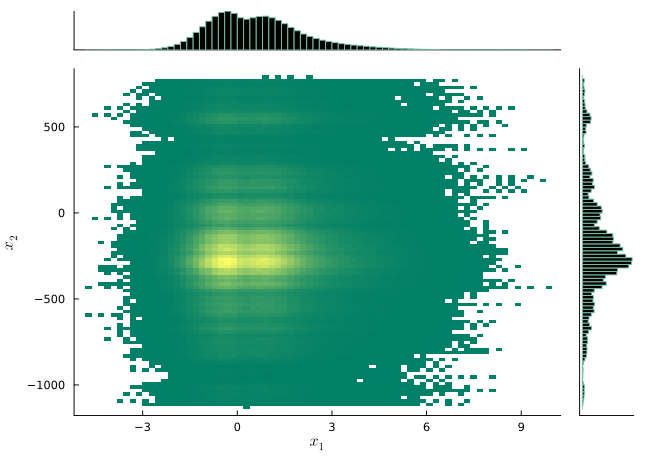

In [6]:
jointplot(samples)

In [7]:
#| eval: false
using PDMPFlux

using Random, Distributions, Plots, LaTeXStrings, Zygote, LinearAlgebra

"""
    Funnel distribution for testing. Returns energy and sample functions.
    For reference, see Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767.
"""
function funnel(d::Int=10, σ::Float64=3.0, clip_y::Int=11)

    function neg_energy(x::Vector{Float64})
        v = x[1]
        log_density_v = logpdf(Normal(0.0, 3.0), v)
        variance_other = exp(v)
        other_dim = d - 1
        cov_other = I * variance_other
        mean_other = zeros(other_dim)
        log_density_other = logpdf(MvNormal(mean_other, cov_other), x[2:end])
        return - log_density_v - log_density_other
    end

    function sample_data(n_samples::Int)
        # sample from Nd funnel distribution
        y = clamp.(σ * randn(n_samples, 1), -clip_y, clip_y)
        x = randn(n_samples, d - 1) .* exp.(-y / 2)
        return hcat(y, x)
    end

    return neg_energy, sample_data
end

function plot_funnel(d::Int=10, n_samples::Int=10000)
    _, sample_data = funnel(d)
    data = sample_data(n_samples)

    # 最初の2次元を抽出（yとx1）
    y = data[:, 1]
    x1 = data[:, 2]

    # 散布図をプロット
    scatter(y, x1, alpha=0.5, markersize=1, xlabel=L"y", ylabel=L"x_1", 
            title="Funnel Distribution (First Two Dimensions' Ground Truth)", grid=true, legend=false, color="#78C2AD")

    # xlim と ylim を追加
    xlims!(-8, 8)  # x軸の範囲を -8 から 8 に設定
    ylims!(-7, 7)  # y軸の範囲を -7 から 7 に設定
end
plot_funnel()

function run_ZigZag_on_funnel(N_sk::Int=100_000, N::Int=100_000, d::Int=10, verbose::Bool=false)
    U, _ = funnel(d)
    grad_U(x::Vector{Float64}) = gradient(U, x)[1]
    xinit = ones(d)
    vinit = ones(d)
    seed = 2024
    grid_size = 0  # constant bounds
    sampler = ZigZag(d, grad_U, grid_size=grid_size)
    out = sample_skeleton(sampler, N_sk, xinit, vinit, seed=seed, verbose = verbose)
    samples = sample_from_skeleton(sampler, N, out)
    return out, samples
end
output, samples = run_ZigZag_on_funnel()  # ４分かかる

jointplot(samples)

In [8]:
using Zygote
@time Zygote.gradient(x -> 3x^2 + 2x + 1, 5)

  1.083900 seconds (3.38 M allocations: 164.987 MiB, 19.68% gc time, 99.98% compilation time)


(32.0,)

In [9]:
f(x::Vector{Float64}) = 3x[1]^2 + 2x[2] + 1
g(x) = Zygote.gradient(f,x)
g([1.0,2.0])

([6.0, 2.0],)

In [10]:
using ForwardDiff
@time ForwardDiff.derivative(x -> 3x^2 + 2x + 1, 5)

  0.005505 seconds (32.12 k allocations: 1.510 MiB, 99.11% compilation time)


32

In [11]:
using Optim
f(x) = (x-1)^2
result = optimize(f, 0.0, 1.0)
result.minimizer

0.999999984947842